# GitHub

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Github
%cd parallel-stencil-unstructured/
%ls -a

/content/gdrive/My Drive/Github
/content/gdrive/My Drive/Github/parallel-stencil-unstructured
 .git/                       mesh_airfoil_fine.mat
 mesh_airfoil_coarse.mat     mesh_airfoil_fine.mat.1
 mesh_airfoil_coarse.mat.1   mesh_airfoil_fine.mat.2
 mesh_airfoil_coarse.mat.2  'mesh_airfoil_fine.mat?dl=0'
 mesh_airfoil_coarse.mat.3  'mesh_airfoil_fine.mat?dl=1'
 mesh_airfoil_coarse.mat.4  'mesh_airfoil_fine.mat?dl=1.1'
 mesh_airfoil_coarse.mat.5  'Swept with advance clean.ipynb'
 mesh_airfoil_coarse.mat.6


In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   Swept with advance clean.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	mesh_airfoil_coarse.mat.1
	mesh_airfoil_coarse.mat.2
	mesh_airfoil_coarse.mat.3
	mesh_airfoil_coarse.mat.4
	mesh_airfoil_coarse.mat.5
	mesh_airfoil_coarse.mat.6
	mesh_airfoil_fine.mat
	mesh_airfoil_fine.mat.1
	mesh_airfoil_fine.mat.2
	mesh_airfoil_fine.mat?dl=0
	mesh_airfoil_fine.mat?dl=1
	mesh_airfoil_fine.mat?dl=1.1

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git add Swept\ with\ advance\ clean.ipynb

## Commit

In [ ]:
!git config --global user.email "moislam@mit.edu"
!git config --global user.name "Mohammad Islam"

In [ ]:
!git commit -m "Removed separate plotting routine for square domain. Now same functions can be used for visualization regardless of the mesh"

[master 8f5ede5] Removed separate plotting routine for square domain. Now same functions can be used for visualization regardless of the mesh
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Swept with advance clean.ipynb (66%)


## Push

In [ ]:
!git push -u origin master

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.48 KiB | 506.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/moislam1221/parallel-stencil-unstructured.git
   41db496..8f5ede5  master -> master
Branch 'master' set up to track remote branch 'master' from 'origin'.


# Import

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from pylab import *
from numpy import *
import scipy.io
from random import shuffle
from collections import defaultdict
import os
BASE_PATH = "/content/gdrive/My Drive/Swept_Advance_Unstructured"

In [3]:
pip install pymetis

     |████████████████████████████████| 307kB 10.3MB/s 
  Created wheel for pymetis: filename=PyMetis-2020.1-cp37-cp37m-linux_x86_64.whl size=275186 sha256=2451e5e54b13c53efced3671eaae80c3fda9214db1656df8ac523b5f2da9e1d0
  Stored in directory: /root/.cache/pip/wheels/c6/95/04/af8144c2245c7562e1cc279b59ca502ff702f04184eb6ea9cf
Successfully built pymetis


In [4]:
import pymetis

In [ ]:
N = 7
neighbors = defaultdict(set)
for i in range(N):
  if i > 0:
    neighbors[i].add(i-1)
  if i < N-1:
    neighbors[i].add(i+1)
seeds = [{0},{N-1}]

print(neighbors)

if 0:
    groundLevel = zeros(N)
    print(groundLevel)
    iIter, territories, stopper, fronts = advance(seeds, 4, groundLevel)
    groundLevel= frontsToGroundLevel(fronts)
    print(groundLevel)
    print(stopper)
    print(territories)

defaultdict(<class 'set'>, {0: {1}, 1: {0, 2}, 2: {1, 3}, 3: {2, 4}, 4: {3, 5}, 5: {4, 6}, 6: {5}})


## Load Airfoil Mesh

In [5]:
!wget https://dl.dropbox.com/s/3wvlm6t22ibcprc/mesh_airfoil_coarse.mat
!wget https://dl.dropbox.com/s/ip5uchjyfuiccqe/mesh_airfoil_fine.mat

--2021-05-27 18:24:45--  https://dl.dropbox.com/s/3wvlm6t22ibcprc/mesh_airfoil_coarse.mat
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/3wvlm6t22ibcprc/mesh_airfoil_coarse.mat [following]
--2021-05-27 18:24:45--  https://dl.dropboxusercontent.com/s/3wvlm6t22ibcprc/mesh_airfoil_coarse.mat
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11222 (11K) [application/octet-stream]
Saving to: ‘mesh_airfoil_coarse.mat’

mesh_airfoil_coarse 100%[===================>]  10.96K  --.-KB/s    in 0s      

2021-05-27 18:24:46 (221 MB/s) - ‘mesh_airfoil_coarse.mat’ saved [11222/1122

# Helper Functions

## Neighbors and xy coordinates

### Rectangle Domain

In [6]:
def create2Dneighbors(N, periodic=True, diagonalLinks=True):
    neighbors = defaultdict(set)
    for j in range(N):
        for i in range(N):
            dof = i + N*j
            # Left and right neighbors
            left = ((i-1) % N)+ N*j
            right = ((i+1) % N)+ N*j
            # Top and bottom neighbors
            top = i + N*((j+1) % N)
            bottom = i + N*((j-1) % N)
            # Diagonal neighbors
            ne = ((i+1) % N) + N*((j+1) % N)
            nw = ((i-1) % N) + N*((j+1) % N)
            se = ((i+1) % N) + N*((j-1) % N)
            sw = ((i-1) % N) + N*((j-1) % N)
            # Add all the neighbors
            if diagonalLinks == True:
                if periodic == True:
                    neighbors[dof].add(left)
                    neighbors[dof].add(right)
                    neighbors[dof].add(top)
                    neighbors[dof].add(bottom)
                    neighbors[dof].add(ne)
                    neighbors[dof].add(nw)
                    neighbors[dof].add(se)
                    neighbors[dof].add(sw)
                else:
                    if i > 0:
                        neighbors[dof].add(left)
                    if i < N-1:
                        neighbors[dof].add(right)
                    if j < N-1:
                        neighbors[dof].add(top)
                    if j > 0:
                        neighbors[dof].add(bottom)
                    # if dof != N*N-1:
                    if i < N-1 and j < N-1:
                        neighbors[dof].add(ne)
                    # if dof != N*N-N:
                    if i > 0 and j < N-1:
                        neighbors[dof].add(nw)
                    # if dof != N-1:
                    if i < N-1 and j > 0:
                        neighbors[dof].add(se)
                    # if dof != 0:
                    if i > 0 and j > 0:
                        neighbors[dof].add(sw)
            else:
                if periodic == True:
                    neighbors[dof].add(left)
                    neighbors[dof].add(right)
                    neighbors[dof].add(top)
                    neighbors[dof].add(bottom)
                else:
                    if i > 0:
                        neighbors[dof].add(left)
                    if i < N-1:
                        neighbors[dof].add(right)
                    if j < N-1:
                        neighbors[dof].add(top)
                    if j > 0:
                        neighbors[dof].add(bottom)
    return neighbors

def coordinatesRectangle(N):
    numDofs = N*N
    xy = np.zeros((numDofs,2))
    dx = 1.0/(N-1)
    x = np.linspace(0,1,N)
    for dof in arange(numDofs):
        idx = int(dof % N)
        idy = int(dof / N)
        xy[dof,:] = np.array((x[idx], x[idy]))
    return xy

def neighborsToEdgesRectangle(N):
    edges = set()
    for dofMain in neighbors:
        for dofSub in neighbors[dofMain]:
            edges.add((dofMain, dofSub) if dofMain < dofSub else (dofSub, dofMain))
    return array(list(edges))

In [7]:
N = 10
xy = np.zeros((N*N,2))
print(xy)
print(xy[10,:])

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[0. 0.]


### Airfoil Case

In [8]:
# Given triangles (each row gives the three node numbers comprising the triangle)
# The edges are given by taking two of the three nodes
# Store edges in array with Nedges subarrays of size two (containg nodes comprising the edge)
def tri2edg(triangles):
    edges = set()
    for t in triangles:
        for i in ([0,1], [1,2], [2,0]):
            e = t[i]
            edges.add((e[0], e[1]) if e[0] < e[1] else (e[1], e[0]))
    return array(list(edges))

def createAirfoilNeighbors():
    # For each node, store all of the neighboring nodes 
    neighbors = defaultdict(set)
    for e in edges:
        neighbors[e[0]].add(e[1])
        neighbors[e[1]].add(e[0])
    return neighbors

## Advance Function

In [9]:
def advance(seeds, nIters, groundLevel):
    fronts = [{1:set(s)} for s in seeds]
    # territories = -ones(len(neighbors), int)
    territories = -ones(len(groundLevel), int)
    for i in range(len(seeds)):
        # print("The " + str(i) + "th seed")
        for p in seeds[i]:
            territories[p] = i
            # print("DOF " + str(p))
    stopper = set()
    iIter = 0
    while iIter + 1 != nIters:
        for iSeed in range(len(seeds)):
            fronts[iSeed][0] = set()
            for ilevel in range(iIter+1, 0, -1):
                for pFront in fronts[iSeed][ilevel]:
                    for pNbr in neighbors[pFront]:
                        if territories[pNbr] < 0 and groundLevel[pNbr] < ilevel:
                            fronts[iSeed][ilevel-1].add(pNbr)
                            territories[pNbr] = iSeed
                        elif territories[pNbr] != iSeed and groundLevel[pNbr] < ilevel:
                            stopper.add(pNbr)
            for ilevel in range(iIter+1, -1, -1):
                fronts[iSeed][ilevel+1] = fronts[iSeed][ilevel]
            del fronts[iSeed][0] 
        if len(stopper):
            break
        iIter = iIter+1
    return iIter, territories, array(list(stopper)), fronts

def checkTerritoriesIntersect(territories):
    territoriesIntersect = False
    numSubdomains = np.max(territories)
    territoriesDofs = []
    for s in np.arange(numSubdomains):
        dofs = np.where(territories == s)
        for dof in dofs[0]:
            for neighbor in list(neighbors[dof]):
                if territories[neighbor] != -1 and territories[neighbor] != s:
                    territoriesIntersect = True
    return territoriesIntersect

def advanceKeepGoing(seeds, nIters, groundLevel):
    fronts = [{1:set(s)} for s in seeds]
    territories = -ones(len(groundLevel), int)
    for i in range(len(seeds)):
        for p in seeds[i]:
            territories[p] = i
    stopper = set()
    iIter = 0
    while iIter + 1 != nIters:
        for iSeed in range(len(seeds)):
            fronts[iSeed][0] = set()
            for ilevel in range(iIter+1, 0, -1):
                for pFront in fronts[iSeed][ilevel]:
                    for pNbr in neighbors[pFront]:
                        if territories[pNbr] < 0 and groundLevel[pNbr] < ilevel:
                            fronts[iSeed][ilevel-1].add(pNbr)
                            territories[pNbr] = iSeed
            for ilevel in range(iIter+1, -1, -1):
                fronts[iSeed][ilevel+1] = fronts[iSeed][ilevel]
            del fronts[iSeed][0] 
        iIter = iIter+1
    return iIter, territories, fronts

def frontsToGroundLevel(fronts):
    for front in fronts:
        for level, points in front.items():
            for point in points:
                groundLevel[point] = level-1
    return groundLevel

## Finding seeds

In [10]:
# STEPS:
# 1 - For each seed set, obtain all the possible neighbors - OK
# 2 - Given the seed set and the possible neighbors, loop through neighbors - OK
# 3 - For each neighbor, add it to the path. Find the next neighbor that is (a) neighbor of current dof, (b) in filament, (c) not seed
# 4 - Determine the dx and dy, and check if the most recent dof has any dof perpendicular to it and add that to the path
# 5 - Loop 3 and 4 until we are about to add a neighbor that is in the seedsList (dont add it and end the path)

def findSeeds(N, nSubdomains):
    # Create array containing how many DOFs per subdomain
    pointsInSubdomain = zeros(nSubdomains, dtype=int)
    nPerSubdomain = round(N / nSubdomains)
    for i in arange(nSubdomains):
        pointsInSubdomain[i] = int(nPerSubdomain)
    if sum(pointsInSubdomain) != N:
        lastNumberOfDofs = N - sum(pointsInSubdomain[:-1])
        pointsInSubdomain[-1] = int(lastNumberOfDofs)
    count = 0
    while abs(pointsInSubdomain[-1] - nPerSubdomain) > 1:
        if pointsInSubdomain[-1] - nPerSubdomain > 1:
            pointsInSubdomain[-1] -= 1
            pointsInSubdomain[count] += 1
        elif nPerSubdomain - pointsInSubdomain[-1] > 1:
            pointsInSubdomain[-1] += 1
            pointsInSubdomain[count] -= 1
        count += 1
    pointsInSubdomain = np.array(sorted(pointsInSubdomain))
    # Partition domain into the subdomains
    domain = zeros((N,N), dtype=int)
    for j in arange(N):
        for i in arange(N):
            domain[i, j] = int(j + i * N)
    subdomainList = []
    for i in arange(nSubdomains):
        for j in arange(nSubdomains):
            xInit = sum(pointsInSubdomain[0:i])
            xFinal = sum(pointsInSubdomain[0:i+1])
            yInit = sum(pointsInSubdomain[0:j])
            yFinal = sum(pointsInSubdomain[0:j+1])
            subdomain = domain[xInit : xFinal, yInit : yFinal]
            subdomainList.append(subdomain)
    # Determine the seed dofs corresponding to each subdomain
    seeds = []
    # Modified approach - working on it
    # (a): Iterate on subdomains to see how many iterations can be performed
    iterationList = []
    for subdomain in subdomainList:
        subdomain = list(np.concatenate(subdomain))
        iter = 0
        while len(subdomain) > 0:
            iter = iter + 1
            subdomainNext = []
            subdomainCurr = subdomain
            for dof in subdomain:
                addToNext = True
                for neighbor in neighbors[dof]:
                    if neighbor not in subdomain:
                        addToNext = False
                if addToNext == True:
                    subdomainNext.append(dof)
            subdomain = subdomainNext
        iterationList.append(iter)
    # (b): Perform number of iterations that is minumum for all sets to the 
    # the appropriate seed
    iterationsToDo = min(iterationList) 
    for i in arange(len(subdomainList)):
        subdomain = subdomainList[i]
        subdomain = list(np.concatenate(subdomain))
        for iter in arange(iterationsToDo):
            subdomainNext = []
            subdomainCurr = subdomain
            for dof in subdomain:
                addToNext = True
                for neighbor in neighbors[dof]:
                    if neighbor not in subdomain:
                        addToNext = False
                if addToNext == True:
                    subdomainNext.append(dof)
            subdomain = subdomainNext
        seeds.append(set(subdomainCurr))
    return seeds

## STEPS
# 1 - determine the lowest level region and pick a random point
# 2 - check all points that lie in region and also are neighbors of that poit
# 3 - check what territories each of the dofs in step 2 are associated with
# 4 - if 4 different territories are present, keep track of the territories. Add our
# original point and its territory. For each dof, if it is part of a new territory
# add the dof and record the territory
# 5 - Check that the four dofs are neighbors of one another
def findSeedsDual(groundLevel, territories):
    dualDofs = []
    nIters = 1000
    for iter in arange(nIters):
        # STEP 1
        minIter = min(groundLevel)
        potentialDualDof = set(np.where(groundLevel == minIter)[0])
        dualDofInit = random.choice(list(potentialDualDof))
        # STEP 2
        neighborsOfDualDofInit = neighbors[dualDofInit]
        dualDofsAttached = potentialDualDof.intersection(neighborsOfDualDofInit)
        # STEP 3
        territoryIDs = set()
        territoryInit = territories[dualDofInit]
        territoryIDs.add(territoryInit)
        for dof in dualDofsAttached:
            territoryID = territories[dof] 
            territoryIDs.add(territoryID)
        # STEP 4
        if len(territoryIDs) == 4:
            territoryTracker = [territoryInit]
            dofTracker = [dualDofInit]
            dualDofsAttached = list(dualDofsAttached)
            random.shuffle(dualDofsAttached)
            for dof in dualDofsAttached:
                territory = territories[dof]
                if territory not in territoryTracker:
                    territoryTracker.append(territory)
                    dofTracker.append(dof)
            #print(dofTracker)
            # STEP 5
            acceptDualDof = True
            for dofMain in dofTracker:   
                for dofSub in dofTracker:
                    if dofMain != dofSub:
                        if dofSub not in neighbors[dofMain]:
                            acceptDualDof = False
            # Add the dualDof if accept dual dof is true
            dualDofsToAdd = set(dofTracker)
            if acceptDualDof == True and dualDofsToAdd not in dualDofs:
                dualDofs.append(set(dofTracker))

    return dualDofs

def simpleBridges(filament, seeds):
    allSeeds = set()
    for i in arange(len(seeds)):
        allSeeds.update(seeds[i])
    allBridges = []
    allBridges = filament.difference(allSeeds)   
    return allBridges

## Plotting

In [61]:
# Added: Plot locations of new and old seeds
# New seeds plotted with "X", old seeds plotted with "O"
def plotSeeds(seeds, imshowStyle, saveFileName = "", dual=False, bridge=False):
    if imshowStyle == True:
        figure(figsize=(12,12))
        N = int(sqrt(len(groundLevel)))
        ground = zeros(N*N)
        for seed in seeds:
            dof = list(seed)
            ground[dof] = 1
        imshow(reshape(ground,[N,N]))
    else:
        figure(figsize=(12,12))
        colorCycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
        for i in range(len(seeds)):
            if dual == False and bridge == False:
                plot(xy[list(seeds[i]), 0], xy[list(seeds[i]), 1], 'X', markersize=20, color=colorCycle[i % len(colorCycle)], label='Seed ' + str(i+1))
            elif dual == True and bridge == False: 
                plot(xy[list(seeds[i]), 0], xy[list(seeds[i]), 1], 'X', markersize=20, color=colorCycle[i % len(colorCycle)], label='Dual Seed ' + str(i+1))
            elif dual == False and bridge == True: 
                plot(xy[list(seeds[i]), 0], xy[list(seeds[i]), 1], 'X', markersize=20, color=colorCycle[i % len(colorCycle)], label='Bridge Seed ' + str(i+1))
            else:
                plot(xy[list(seeds[i]), 0], xy[list(seeds[i]), 1], 'X', markersize=20, color=colorCycle[i % len(colorCycle)], label='Dual Bridge Seed ' + str(i+1))
        axis('scaled')
        legend(fontsize=20)
        tick_params(labelsize=20)
        tight_layout()
    if saveFileName != "":
        savefig(BASE_PATH + '/' + subPath + '/' + saveFileName, dpi = 300)
    return 0

def plotTerritories(territorySet, imshowStyle, saveFileName = "", legendFlag=True, dual=False):
    if imshowStyle == True:
        figure(figsize=(12,12))
        N = int(sqrt(len(groundLevel)))
        ground = zeros(N*N)
        for i in range(len(territorySet)):
            dofs = list(territorySet[i])
            ground[dofs] = 1
        imshow(reshape(ground,[N,N]))
        colorbar()
    else:
        figure(figsize=(12,12))
        colorCycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
        for i in range(len(territorySet)):
            if dual == False:
                plot(xy[list(territorySet[i]), 0], xy[list(territorySet[i]), 1], 'o', markersize=10, color=colorCycle[i % len(colorCycle)], label='Subdomain ' + str(i+1))
            else:
                plot(xy[list(territorySet[i]), 0], xy[list(territorySet[i]), 1], 'o', markersize=10, color=colorCycle[i % len(colorCycle)], label='Dual Subdomain ' + str(i+1))
        axis('scaled')
        tick_params(labelsize=20)
        tight_layout()
        if legendFlag == True:
            legend(fontsize=20) 
    if saveFileName != "":
        savefig(BASE_PATH + '/' + subPath + '/' + saveFileName, dpi = 300)
    return 0

def plotGroundLevel(groundLevel, imshowStyle, saveFileName = ""):
    if imshowStyle == True:
        fig = figure(figsize=(12,12))
        N = int(sqrt(len(groundLevel)))
        imshow(reshape(groundLevel, [N,N]))
        colorbar(cmap='jet')
    else: 
        # Original color cycle plotting
        #
        # figure(figsize=(12,12))
        # plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
        # colorCycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        # maxLevel = int(max(groundLevel))
        # minLevel = int(min(groundLevel))
        # for i in range(minLevel, maxLevel+1):
        #     plot(xy[groundLevel == i, 0].T, xy[groundLevel == i, 1].T, 'o', color=colorCycle[i % len(colorCycle)], markersize=10, label=str(i) + " Iterations")
        # legend(fontsize=20)
        #
        fig = figure(figsize=(12,12))
        plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
        gMax = int(max(groundLevel))
        gMin = int(min(groundLevel))
        if gMin != gMax:
            colorInput = (groundLevel - gMin) / (gMax - gMin)
        else:
            colorInput = 0.5 * ones(len(groundLevel))
        viridis = cm.get_cmap('viridis', 12)
        colorArray = viridis(colorInput)
        for i in range(len(xy)):
        #    print(i)
        #    if gMin != gMax:
            plot(xy[i, 0].T, xy[i, 1].T, 'o', color = colorArray[i], markersize=10)
        #    else:
        #        plot(xy[i, 0].T, xy[i, 1].T, 'o', color = colorArray, markersize=10)
        axis('scaled')
        tick_params(labelsize=20)
        cmap = cm.viridis
        norm = matplotlib.colors.Normalize(vmin=gMin, vmax=gMax)
        cbar = colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), shrink=0.75)
        cbar.set_ticks(arange(gMin,gMax+1))
        cbar.ax.tick_params(labelsize=20)
        tight_layout()
    if saveFileName != "":
        savefig(BASE_PATH + '/' + subPath + '/' + saveFileName, dpi = 300)
    return 0

def plotTerritoriesSubdomains(territorySet, imshowStyle, saveFileName = ""):
    numTerritories = len(territorySet)
    fig, axs = plt.subplots(1, numTerritories, figsize=(6*numTerritories,6))
    if imshowStyle == True:
        for i in range(len(territorySet)):
            N = int(sqrt(len(groundLevel)))
            ground = zeros(N*N)
            dofs = list(territorySet[i])
            ground[dofs] = 1
            if numTerritories > 1:
                axs[i].imshow(reshape(ground,[N,N]))
            else:
                axs.imshow(reshape(ground,[N,N]))
    else:
        colorCycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        if numTerritories > 1:
            for i in range(len(territorySet)):
                axs[i].plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
                axs[i].plot(xy[list(territorySet[i]), 0], xy[list(territorySet[i]), 1], 'o', markersize=10, color=colorCycle[i % len(colorCycle)])
                axs[i].axis('square')
                axs[i].tick_params(labelsize=20)
                fig.tight_layout()
        else:
            i = 0
            axs.plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
            axs.plot(xy[list(territorySet[i]), 0], xy[list(territorySet[i]), 1], 'o', markersize=10, color=colorCycle[i % len(colorCycle)])
            axis('square')
            legend(fontsize=20)
            tick_params(labelsize=20)
            tight_layout()
            show()
    if saveFileName != "":
        savefig(BASE_PATH + '/' + subPath + '/' + saveFileName, dpi = 300)
    return 0

def plotTerritoriesSubdomainsGroundLevel(territorySet, groundLevel, imshowStyle, saveFileName = ""):
    numTerritories = len(territorySet)
    fig, axs = plt.subplots(1, numTerritories, figsize=(6*numTerritories,6))
    if imshowStyle == True:
        for i in range(len(territorySet)):
            N = int(sqrt(len(groundLevel)))
            ground = zeros(N*N)
            dofs = list(territorySet[i])
            ground[dofs] = 1
            if numTerritories > 1:
                axs[i].imshow(reshape(ground,[N,N]))
            else:
                axs.imshow(reshape(ground,[N,N]))
    else:
        gMax = int(max(groundLevel))
        gMin = int(min(groundLevel))
        if gMin != gMax:
            colorInput = (groundLevel - gMin) / (gMax - gMin)
        else:
            colorInput = 0.5 * ones(len(groundLevel))
        viridis = cm.get_cmap('viridis', 12)
        if numTerritories > 1:
            for i in range(len(territorySet)):
                dofs = list(territorySet[i])
                colorInputTerritory = colorInput[dofs]
                colorArray = viridis(colorInputTerritory)
                axs[i].plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
                for j in range(len(dofs)):
                    axs[i].plot(xy[dofs[j], 0], xy[dofs[j], 1], 'o', markersize=10, color=colorArray[j])
                axs[i].axis('square')
                axs[i].tick_params(labelsize=20)
                fig.tight_layout()
        else:
            i = 0
            dofs = list(territorySet[i])
            colorInputTerritory = colorInput[dofs]
            colorArray = viridis(colorInputTerritory)
            axs.plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
            for j in range(len(dofs)):
                axs.plot(xy[dofs[j], 0], xy[dofs[j], 1], 'o', markersize=10, color=colorArray[j])
            axs.axis('square')
            axs.tick_params(labelsize=20)
            fig.tight_layout()
        cmap = cm.viridis
        norm = matplotlib.colors.Normalize(vmin=gMin, vmax=gMax)
        fig.subplots_adjust(right=0.95, wspace=0.15, hspace=0.02)
        cbar_ax = fig.add_axes([0.96, 0.12, 0.015, 0.8])
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, shrink=1)
        cbar.set_ticks(arange(gMin,gMax+1))
        cbar.ax.tick_params(labelsize=20)
    if saveFileName != "":
        savefig(BASE_PATH + '/' + subPath + '/' + saveFileName, dpi = 300)
    return 0

## Visualization and saving solution

In [12]:
def visualizeAndSaveUpperPyramidal(seedsOriginal, territorySetOriginal, seeds, territorySetUpperPyramidal, groundLevel, saveFlag = False, imshowStyle = False):
    # Establish file names
    seedOriginalFile = ""
    territoryOriginalFile = ""
    territoryOriginalSubdomainFile = ""
    seedFile = ""
    territoryFile = ""
    groundLevelFile = ""
    if saveFlag == True:  
        if airfoilMeshFlag == True:
            baseName = 'upperPyramidal_' + 'seeds' + str(len(seeds)) + '_airfoil'
        else: 
            baseName = 'upperPyramidal_' + 'N' + str(N) + '_' + 'seeds' + str(len(seeds)) + '_square'
        seedOriginalFile = baseName + '_seedsInitial.png'
        territoryOriginalFile = baseName + '_territoriesInitial.png'
        territoryOriginalSubdomainFile = baseName + '_territoriesInitialSubdomains.png'
        seedFile = baseName + '_seeds.png'
        territoryFile = baseName + '_territories.png'
        groundLevelFile = baseName + '_groundLevel.png'
    # Plot and possibly save figures
    if airfoilMeshFlag == True:
        plotSeeds(seedsOriginal, imshowStyle, seedOriginalFile)
        plotTerritories(territorySetOriginal, imshowStyle, territoryOriginalFile)
        plotTerritories(territorySetUpperPyramidal, imshowStyle, territoryFile)
        plotSeeds(seeds, imshowStyle, seedFile)
        plotGroundLevel(groundLevel, imshowStyle, groundLevelFile)
    else:
        plotSeeds(seedsOriginal, imshowStyle, seedOriginalFile)
        plotTerritories(territorySetOriginal, imshowStyle, territoryOriginalFile)
        plotTerritoriesSubdomains(territorySetOriginal, imshowStyle, territoryOriginalSubdomainFile)
        plotTerritoriesSubdomains(territorySetUpperPyramidal, imshowStyle, territoryFile)
        plotSeeds(seeds, imshowStyle, seedFile)
        plotGroundLevel(groundLevel, imshowStyle, groundLevelFile)
    return 0

def visualizeAndSaveFiguresBridge(dualSeeds, territorySetDualSeedsExpanded, filament, bridges, territorySetBridge, groundLevel, saveFlag = False, imshowStyle = False):
    # Establish file names
    dualSeedFile = ""
    dualSeedTerritoryFile = ""
    allBridgeDofsFile = ""
    bridgesFile = ""
    territoryFile = ""
    groundLevelFile = ""
    if saveFlag == True:
        if airfoilMeshFlag == True:
            baseName = 'bridge_' + 'seeds' + str(len(seeds)) + '_airfoil'
        else: 
            baseName = 'bridge_' + 'N' + str(N) + '_' + 'seeds' + str(len(seeds)) + '_square'
        dualSeedFile = baseName + '_dualSeeds.png'
        dualSeedTerritoryFile = baseName + '_dualSeedTerritory.png'
        allBridgeDofsFile = baseName + '_filament.png'
        bridgesFile = baseName + '_bridges.png'
        territoryFile = baseName + '_territories.png'
        groundLevelFile = baseName + '_groundLevel.png'
    # Plot and possibly save figures
    plotSeeds(dualSeeds, imshowStyle, dualSeedFile, dual=True)
    plotTerritories(territorySetDualSeedsExpanded, imshowStyle, dualSeedTerritoryFile, dual=True)
    plotTerritories([filament],  imshowStyle, allBridgeDofsFile, legendFlag=False)
    plotTerritoriesSubdomains(bridges, imshowStyle, bridgesFile)
    plotTerritoriesSubdomains(territorySetBridge, imshowStyle, territoryFile)
    plotGroundLevel(groundLevel, imshowStyle, groundLevelFile)
    return 0

def visualizeAndSaveFiguresLowerPyramidal(territorySetLowerPyramidal, groundLevel, saveFlag = False, imshowStyle = False):
    # Establish file names
    territoryFile = ""
    groundLevelFile = ""
    if saveFlag == True:
        if airfoilMeshFlag == True:
            baseName = 'lowerPyramidal_' + 'seeds' + str(len(seeds)) + '_airfoil'
        else: 
            baseName = 'lowerPyramidal_' + 'N' + str(N) + '_' + 'seeds' + str(len(seeds)) + '_square'
        territoryFile = baseName + '_territories.png'
        groundLevelFile = baseName + '_groundLevel.png'
    # Plot and possibly save figures
    plotTerritories(territorySetLowerPyramidal, imshowStyle, territoryFile, dual=True)
    plotGroundLevel(groundLevel, imshowStyle, groundLevelFile)
    return 0

def visualizeAndSaveDualBridge(territorySetSeedsExpanded, filament, dualBridges, territorySetDualBridge, groundLevel, saveFlag = False, imshowStyle = False):
    # Establish file names
    seedTerritoryFile = ""
    allDualBridgeDofsFile = ""
    dualBridgesFile = ""
    territoryFile = ""
    groundLevelFile = ""
    if saveFlag == True:
        if airfoilMeshFlag == True:
            baseName = 'dualBridge_' + 'seeds' + str(len(seeds)) + '_airfoil'
        else: 
            baseName = 'dualBridge_' + 'N' + str(N) + '_' + 'seeds' + str(len(seeds)) + '_square'
        seedTerritoryFile = baseName + "_seedTerritory.png"
        allDualBridgeDofsFile = baseName + '_filament.png'
        dualBridgesFile = baseName + '_bridges.png'
        territoryFile = baseName + '_territories.png'
        groundLevelFile = baseName + '_groundLevel.png'
    # Plot and possibly save figures
    plotTerritories(territorySetSeedsExpanded, imshowStyle, seedTerritoryFile)
    plotTerritories([filament], imshowStyle, allDualBridgeDofsFile, legendFlag=False)
    plotTerritoriesSubdomains(dualBridges, imshowStyle, dualBridgesFile)
    plotTerritoriesSubdomains(territorySetDualBridge, imshowStyle, territoryFile)
    plotGroundLevel(groundLevel, imshowStyle, groundLevelFile)
    return 0

## Parallel Advance Functions

In [13]:
def expandTerritorySet(territorySet, neighbors):
    territorySetExpanded = []
    for i in range(len(territorySet)):
        setToAdd = set()
        for dof in list(territorySet[i]):
            setToAdd.add(dof)
            for neighbor in neighbors[dof]:
                setToAdd.add(neighbor)
        territorySetExpanded.append(setToAdd)
    return territorySetExpanded

def groundLevelPartition(groundLevel, territorySet, seeds, neighbors):
    groundLevelAllSubdomains = []
    for i in range(len(seeds)):
        subdomainListToAdd = defaultdict(list)
        for dof in territorySet[i]:
            subdomainListToAdd[dof] = int(groundLevel[dof])
        groundLevelAllSubdomains.append(subdomainListToAdd)
    return groundLevelAllSubdomains

def parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySet, seeds, nIters, neighbors):
    for i in range(len(seeds)):
        updateList = []
        updateList.append(seeds[i])
        levelStart = min(groundLevel)
        thresholdLevelList = [levelStart+1]
        for iter in range(nIters):
            updateListAll = []
            for idx in range(len(updateList)):
                updateListAll.append(list(updateList[idx]))
            updateListAll = concatenate(updateListAll)
            for s in range(len(updateList)):
                updateSetNext = set()
                for dof in updateList[s]:
                    ## update: check if all my neighbors present in subdomain before doing the update
                    updateDof = True
                    for neighbor in neighbors[dof]:
                        if neighbor not in groundLevelAllSubdomains[i]:
                            updateDof = False
                    currentLevel = groundLevelAllSubdomains[i][dof]
                    if currentLevel < thresholdLevelList[s] and updateDof == True:
                        groundLevelAllSubdomains[i][dof] = groundLevelAllSubdomains[i][dof] + 1
                        for neighbor in neighbors[dof]:
                            if neighbor in groundLevelAllSubdomains[i] and neighbor not in updateListAll:
                                if groundLevelAllSubdomains[i][neighbor] < thresholdLevelList[s]:
                                    if s < len(updateList)-1:
                                        updateList[s+1].add(neighbor)
                                    else:
                                        updateSetNext.add(neighbor)                                    
            for idx2 in range(len(thresholdLevelList)):
                thresholdLevelList[idx2] += 1
            thresholdLevelList.append(levelStart+1)
            updateList.append(updateSetNext)
            
    return groundLevelAllSubdomains

def groundLevelCombine(groundLevelInput, groundLevelAllSubdomains, territorySet = []):
    groundLevel = groundLevelInput.copy()
    for i in range(len(groundLevelAllSubdomains)):
        for dof in groundLevelAllSubdomains[i]:
            if len(territorySet) == 0:
                groundLevel[dof] = groundLevelAllSubdomains[i][dof]
            elif dof in territorySet[i]:
                groundLevel[dof] = groundLevelAllSubdomains[i][dof]
    return groundLevel

# STEP 1: UPPER PYRAMIDAL

## Functions

In [14]:
def findSeedsApart(neighbors, numSeeds, nTrials=2000):
    # Initialize stuff
    numDofs = len(neighbors)
    seeds = random.choice(numDofs, size=numSeeds, replace=False)
    seeds = [set([s]) for s in seeds]
    groundLevel = zeros(numDofs)
    maxIter = 0
    savedSeeds = []
    # Figure out how far apart (how many iters max) can be done
    for trial in range(nTrials):
        if trial % 50 == 0:
            print("TRIAL " + str(trial) + "/" + str(nTrials))
        iIter, territories, stopper, _ = advance(seeds, 0, groundLevel)
        if iIter > maxIter:
            print("iIter has gone up to " + str(iIter))
            maxIter = iIter
            savedSeeds = seeds
        _, territories2,_,_ = advance([stopper], iIter+1, groundLevel)
        seeds = moveSeeds(seeds, territories2)
    # Find a seed configuration corresponding to this max iter
    #iIter = 0
    #while iIter < maxIter:
    #    _, territories2,_,_ = advance([stopper], iIter+1, groundLevel)
    #    seeds = moveSeeds(seeds, territories2)
    #    iIter, territories, stopper, _ = advance(seeds, 0, groundLevel)
    #    print(iIter)
    seeds = savedSeeds
    return seeds

def createSubdomainsWithMETIS(neighbors, seeds, territories):
    # Create useful data structures containing seed, territory info
    territorySet = territorySetCreator(territories)
    seedsList, territoryList = seedAndTerritoryListCreator(seeds, territorySet)
    # Remove all neighbors of nodes lying in a territory
    for i in range(len(seeds)):
        for dof in territorySet[i]:
            neighbors[dof].clear()
    # Link seeds to all neighbors of the territory dofs
    neighborsOfTerritory = getNeighborsOfTerritory(seeds, territorySet)
    for i in range(len(seeds)):
        seedDof = list(seeds[i])[0]
        neighbors[seedDof] = set(neighborsOfTerritory[i])
    # Replace any territory dof in the connectivity with the representative seed
    for dof in range(len(neighbors)):
        for neighbor in neighbors[dof].copy():
            for i in range(len(seeds)):
                if neighbor in territorySet[i]:
                    neighbors[dof].remove(neighbor)
                    neighbors[dof].add(list(seeds[i])[0])
    # Create METIS adjacency list and vweights data structures (arrays)
    adjacency_list = []
    vweights = []
    ratioNonSeedToSeed = int(numDofs - len(seeds) / len(seeds))
    hugeFactor = 10000
    seedWeight = hugeFactor * ratioNonSeedToSeed
    for i in range(numDofs):
        adjacency_list.append(np.array(list(neighborsDummy[i])))
        if i in seedsList:
            vweights.append(seedWeight)
        else:
            vweights.append(1)
    # Use METIS to partition the domain
    numSubdomains = len(seeds)
    territorySetAllDofs = []
    n_cuts, membership = pymetis.part_graph(numSubdomains, adjacency=adjacency_list, vweights=vweights)
    for i in range(numSubdomains):
        nodes_partition = np.argwhere(np.array(membership) == i).ravel() # [3, 5, 6]
        territorySetAllDofs.append(set(nodes_partition))
    # Remove dofs which were in the territory but not the seed
    for sub in range(numSubdomains):
        for dof in territorySetAllDofs[sub].copy():
            if (dof not in seedsList):
                if dof in territoryList:
                    territorySetAllDofs[sub].remove(dof)
    # In each region, find the seed and augment the list with all the territory dofs corresponding to the seed
    metisToTerritories = []
    for sub in range(numSubdomains):
        for dof in territorySetAllDofs[sub].copy():
            if dof in seedsList:
                idx = np.where(dof == seedsList)[0][0]
                territorySetAllDofs[sub].update(territorySet[idx])
    return territorySetAllDofs

def permuteMETISToOriginalOrder(territorySetUpperPyramidal, seedsOriginal):
    # Obtain the permutation of METIS ordering to original by finding which territories each seed is in
    permute = []
    for seedSet in seedsOriginal:
        seed = list(seedSet)[0]
        for i in range(len(territorySetUpperPyramidal)):
            if seed in territorySetUpperPyramidal[i]:
                permute.append(i)
    # Rearrange territorySet from METIS to line up with original ordering (this is nice for plotting before and after with subdomains plotted the same color)
    territorySetReordered = []
    for i in range(len(territorySetUpperPyramidal)):
        territorySetReordered.append(territorySetUpperPyramidal[permute[i]])
    return territorySetReordered

def upperPyramidal(territorySetAllDofs, neighbors):
    numSubdomains = len(territorySetAllDofs)
    iterationList = []
    # Determine max iters that can be performed overall (min of all iters)
    for s in range(numSubdomains):
        iter = 0
        currentDofs = list(territorySetAllDofs[s])
        while len(currentDofs) > 0:
            updatedDofs = []
            for dof in currentDofs:
                updateTheDof = True
                for n in neighbors[dof]:
                    if n not in currentDofs:
                        updateTheDof = False
                if updateTheDof == True:
                    updatedDofs.append(dof)
            currentDofs = updatedDofs
            if len(updatedDofs) > 0:
                iter = iter + 1
        iterationList.append(iter)
    # Obtain seeds from performing that many iterations
    iterationsToDo = min(iterationList) 
    seeds = []
    for s in range(numSubdomains):
        iter = 0
        currentDofs = list(territorySetAllDofs[s])
        for iter in range(iterationsToDo):
            updatedDofs = []
            for dof in currentDofs:
                updateTheDof = True
                for n in neighbors[dof]:
                    if n not in currentDofs:
                        updateTheDof = False
                if updateTheDof == True:
                    updatedDofs.append(dof)
            currentDofs = updatedDofs
        seeds.append(set(currentDofs))
    # Return seed values
    return seeds

In [15]:
def moveSeeds(seeds, territories):
    seedsNew = []
    territoryDofs = set(np.where(territories == 0)[0])
    p = np.random.rand()
    for s in seeds:
        neighborInStopperTerritory = False
        for dof in neighbors[list(s)[0]]:
            if dof in territoryDofs:
                neighborInStopperTerritory = True
        if (list(s)[0] in territoryDofs) or (neighborInStopperTerritory == True):
            potentialSeeds = neighbors[list(s)[0]].difference(territoryDofs)
            if len(potentialSeeds) > 0:
                seedsNew.append(random.choice(list(potentialSeeds)))
            else:
                seedsNew.append(list(s)[0])
        else:
            seedsNew.append(list(s)[0])
    seedsNew = [set([s]) for s in seedsNew]
    return seedsNew

def territorySetCreator(territories):
    territorySet = []
    for i in range(max(territories)+1):
        territoryDofs = set(np.where(territories == i)[0])
        territorySet.append(territoryDofs)
    return territorySet

def seedAndTerritoryListCreator(seeds, territorySet):
    seedsList = []
    territoryList = []
    for i in range(len(seeds)):
        seedsList.append(list(seeds[i])) 
        territoryList.append(list(territorySet[i]))
    seedsList = np.concatenate(seedsList)
    territoryList = np.concatenate(territoryList)
    return seedsList, territoryList

def getNeighborsOfTerritory(seeds, territorySet):
    neighborsOfTerritory = []
    for i in range(len(seeds)):
        territoryNeighbors = []
        for dof in territorySet[i]:
            territoryNeighbors.append(list(neighbors[dof]))
        neighborsOfTerritory.append(set(np.concatenate(territoryNeighbors)))
    for i in range(len(seeds)):
        neighborsOfTerritory[i] = set(neighborsOfTerritory[i]).difference(set(territorySet[i])) 
    return neighborsOfTerritory

# STEP 2: DUAL SEED UPDATE

## Functions

In [16]:
def findDualSeeds(groundLevel, territorySetUpperPyramidal, neighbors):
    # Find all dofs at the lowest iteration level after upper pyramidal
    minIter = min(groundLevel)
    potentialDualDofs = set(np.where(groundLevel == minIter)[0])
    potentialDualDofs.update(set(np.where(groundLevel == minIter+1)[0]))
    # Determine which dofs have the most territories represented in the set of points containing their neighbors and themselves
    territoriesRepByDof = numTerritoriesRepByNeighbors(potentialDualDofs, territorySetUpperPyramidal, neighbors)
    dualSeedDofs = potentialDualSeeds(territoriesRepByDof)
    # Group the dual seeds into different sets of points which are contiguous 
    dualSeeds = groupDualSeeds(dualSeedDofs, neighbors)
    return dualSeeds

def groupDualSeeds(dualSeedDofs, neighbors):  
    dualSeeds = []
    dofSet = set(dualSeedDofs)
    while(len(dofSet)) > 0:
        seedSet = set()
        seedSet.add(list(dofSet)[0])
        idx = 0
        repeat = True
        while repeat == True:
            dofMain = list(seedSet)[idx]
            repeat = False
            for dof2 in list(dofSet):
                if dofMain != dof2:
                    areNeighbors = determineIfDofsAreNeighbors(dofMain, dof2)
                    if areNeighbors == True and dof2 not in seedSet:
                        seedSet.add(dof2)
                        repeat = True
            if repeat == True:
                idx = idx + 1
        dofSet.difference_update(seedSet)
        dualSeeds.append(seedSet)
    return dualSeeds

def removeCloseSeeds(dualSeeds, iIter, groundLevel, neighbors):
    zeroGroundLevel = zeros(len(groundLevel))
    stopperExists = True
    while stopperExists == True:
        # Advance the dual seeds
        _, territories, stopper, _ = advance(dualSeeds, iIter, zeroGroundLevel)
        territorySet = territorySetCreator(territories)
        # plotTerritories(territories, N)
        # plotTerritoriesAll(territories, N)
        if len(stopper) > 0:
            stopperDof = random.choice(stopper)
            terrID = territoryFinder(territorySet, stopperDof)
            dualSeeds.remove(dualSeeds[terrID])
        else:
            stopperExists = False
    return dualSeeds

def numTerritoriesRepByNeighbors(dofSet, territorySetAllDofs, neighbors):
    # Obtain the number of territories represented by dof
    territoriesRepByDof = defaultdict()
    for dof in dofSet:
        territoryIDs = set()
        territoryIDs.add(territoryFinder(territorySetAllDofs, dof))
        neighborSet = neighbors[dof]
        for neighbor in neighborSet:  
            territoryID = territoryFinder(territorySetAllDofs, neighbor) 
            territoryIDs.add(territoryID)
        territoriesRepByDof[dof] = len(territoryIDs)
    return territoriesRepByDof

def potentialDualSeeds(territoriesRepByDof):
    max_value = max(territoriesRepByDof.values())  # maximum value
    print(max_value)
    dualSeedDofs = [k for k, v in territoriesRepByDof.items() if v == max_value] # getting all keys containing the `maximum`
    return dualSeedDofs

def determineIfDofsAreNeighbors(dof1, dof2):
    areNeighbors = False
    neighborSet = neighbors[dof1]
    for neighbor in neighborSet:
        if neighbor == dof2:
            areNeighbors = True
    return areNeighbors

def obtainFilamentBridgeRegion(dualSeeds, groundLevel):
    iIter, territories, stopper, fronts = advance(dualSeeds, max(groundLevel)-min(groundLevel), zeros(len(groundLevel)))
    #figure()
    #imshow(reshape(territories >= 0, [N,N]))
    #colorbar()
    filament = set(np.where(territories == -1)[0])  
    return filament

def filamentRemoveSeeds(filament, seeds):
    for i in range(len(seeds)):
        filament.difference_update(seeds[i])
    return filament

def territoryFinder(territorySetAllDofs, dof):
    territoryID = -1
    for i in range(len(territorySetAllDofs)):
        if dof in territorySetAllDofs[i]:
            territoryID = i
    if territoryID == -1:
        print("A territory wasn't found")
    return territoryID

In [17]:
def filamentConnectivityConstructor(filament, neighbors, groundLevel):
    filamentConnectivity = defaultdict()
    for dof in filament:
        allNeighbors = set()
        currentLevel = int(groundLevel[dof])
        maxLevel = int(max(groundLevel))
        mylist = set()
        if currentLevel < maxLevel:
            mylist.add(dof)
        levelGap = 1
        while len(mylist) > 0:
            lowDofs = set()
            for dofIter in mylist:
                for neighbor in neighbors[dofIter]:
                    allNeighbors.add(neighbor)
                    if groundLevel[neighbor] < maxLevel-levelGap:
                        lowDofs.add(neighbor)
            mylist = lowDofs.copy()
            levelGap += 1
        filamentConnectivity[dof] = allNeighbors
    return filamentConnectivity

# Construct a graph connecting all dofs in filaments to all other dofs, with weighting equal to intersection of regions of dependence
def filamentMappingforMETIS(filament):
    map = defaultdict()
    reverseMap = defaultdict()
    i = 0
    for dof in filament:
        map[dof] = i
        reverseMap[i] = dof 
        i += 1
    return map, reverseMap

def constructMappedFilamentAndConnectivity(filament, filamentConnectivity, map):
    filamentMapped = set()
    filamentConnectivityMapped = defaultdict()
    for dof in filament:
        filamentMapped.add(map[dof])
        filamentConnectivityMapped[map[dof]] = filamentConnectivity[dof]
    return filamentMapped, filamentConnectivityMapped

def constructMETISDataStructures(filamentMapped, filamentConnectivityMapped):
    xadj = []
    adjncy = []
    eweights = []
    for dof in filamentMapped:
        xadj.append(len(adjncy))
        filamentMappedNoDof = filamentMapped.difference({dof})
        for dof2 in filamentMappedNoDof:
            eweight = len(filamentConnectivityMapped[dof].intersection(filamentConnectivityMapped[dof2]))
            if eweight > 0:
                adjncy.append(dof2)
                eweights.append(eweight)
    xadj.append(len(adjncy))
    return xadj, adjncy, eweights

def constructMETISDataStructures(filamentMapped, filamentConnectivityMapped):
    xadj = []
    adjncy = []
    eweights = []
    for dof in filamentMapped:
        xadj.append(len(adjncy))
        filamentMappedNoDof = filamentMapped.difference({dof})
        for dof2 in filamentMappedNoDof:
            eweight = len(filamentConnectivityMapped[dof].intersection(filamentConnectivityMapped[dof2]))
            if eweight > 0:
                adjncy.append(dof2)
                eweights.append(eweight)
        
    xadj.append(len(adjncy))
    return xadj, adjncy, eweights

def membershipToBridges(nparts, membership, reverseMap):
    bridges = []
    for IDno in range(nparts):
        bridgeSet = set()
        for dof in range(len(membership)):
            ID = membership[dof]
            if ID == IDno:
                actualDof = reverseMap[dof]
                bridgeSet.add(actualDof)
        bridges.append(bridgeSet)
    return bridges

def createMETISGraphFile(xadj, adjncy, eweights):
    # Initialize the file for writing
    f = open("filamentGraphFile.txt","w+")
    # Determine useful parameters and write first line
    numNodes = len(xadj) - 1
    numEdges = int(len(eweights) / 2)
    f.write(str(numNodes) + " " + str(int(numEdges)) + " " + "001\n" )
    # Write subsequent lines of (dof,weight) which are connected to dof i in the ith line
    for i in range(numNodes):
        idxInit = xadj[i]
        idxFinal = xadj[i+1]
        for j in range(idxInit, idxFinal):
            dof = adjncy[j]
            weight = eweights[j]
            f.write(str(dof) + " " + str(weight) + " ")
        f.write("\n")
    # Close the file
    f.close()
    return 

## Test Case of Bridge Connectivity

In [18]:
## MAIN ##

# Initialization 
N = 5
nSubdomains = 1
periodicFlag = False
diagonalLinksFlag = True
neighbors = create2Dneighbors(N, periodic=periodicFlag, diagonalLinks=diagonalLinksFlag)
seeds = [{int(N*N/2)}]

# Advance!
groundLevel = zeros(N*N)
iIter, territories, stopper, fronts = advance(seeds, 4, groundLevel)
groundLevel = frontsToGroundLevel(fronts)
#plotGroundLevel(groundLevel, N)

In [19]:
# Define all points in filament
filament = set()
filament.update(arange(N*N))
filamentConnectivity = filamentConnectivityConstructor(filament, neighbors, groundLevel)
print(filamentConnectivity)

defaultdict(None, {0: {0, 1, 2, 5, 6, 7, 10, 11}, 1: {0, 1, 2, 3, 5, 6, 7, 8, 10, 11}, 2: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, 3: {1, 2, 3, 4, 6, 7, 8, 9, 13, 14}, 4: {2, 3, 4, 7, 8, 9, 13, 14}, 5: {0, 1, 2, 5, 6, 7, 10, 11, 15, 16}, 6: {0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 15, 16}, 7: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 8: {1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 14, 18, 19}, 9: {2, 3, 4, 7, 8, 9, 13, 14, 18, 19}, 10: {0, 1, 5, 6, 10, 11, 15, 16, 20, 21}, 11: {0, 1, 5, 6, 7, 10, 11, 12, 15, 16, 17, 20, 21}, 12: set(), 13: {3, 4, 7, 8, 9, 12, 13, 14, 17, 18, 19, 23, 24}, 14: {3, 4, 8, 9, 13, 14, 18, 19, 23, 24}, 15: {5, 6, 10, 11, 15, 16, 17, 20, 21, 22}, 16: {5, 6, 10, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23}, 17: {11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}, 18: {8, 9, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24}, 19: {8, 9, 13, 14, 17, 18, 19, 22, 23, 24}, 20: {10, 11, 15, 16, 17, 20, 21, 22}, 21: {10, 11, 15, 16, 17, 18, 20, 21, 22, 23}, 22: {15, 16, 17, 18, 19, 20, 21, 22, 23, 24}

# STEP 3: LOWER PYRAMIDAL

## Functions

In [20]:
def lowerPyramidal(neighbors, groundLevel):
    seeds = []
    minIter = min(groundLevel)
    for dof in range(N*N):
        if groundLevel[dof] == minIter:
            seedList = [dof]
            for neighbor in neighbors[dof]:
                if groundLevel[neighbor] == minIter:
                    seedList.append(neighbor)
            if set(seedList) not in seeds:
                seeds.append(set(seedList))
    nIters = 2*max(groundLevel) + 1
    iIter, territories, stopper, fronts = advance(seeds, nIters, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)
    return groundLevel

# STEP 4: DUAL BRIDGES

# STEP 5: (Repeat step 1)

# MAIN

## INITIALIZE

## Inputs

In [106]:
# Initialization 

# Define mesh settings

# Check if we want to run airfoil mesh
airfoilMeshFlag = False
airfoilFineFlag = False

# If not, we want to run square mesh. The following parameters are important then
N = 50
nSubdomains = 4
periodicFlag = False
diagonalLinksFlag = True

# Should we run mimicking parallel?
PARALLEL_FLAG = True

# Should we save figures
saveFiguresFlag = True

In [107]:
# Create the neighbors structure based on inputs
if airfoilMeshFlag == True:
    # Load mat file
    if airfoilFineFlag == True:
        mat = scipy.io.loadmat('mesh_airfoil_fine.mat')
    else:
        mat = scipy.io.loadmat('mesh_airfoil_coarse.mat')
    xy = mat['p']
    edges = tri2edg(mat['t']) - 1
    neighbors = createAirfoilNeighbors()
    imshowFlag = False
else:
    neighbors = create2Dneighbors(N, periodic=periodicFlag, diagonalLinks=diagonalLinksFlag)
    xy = coordinatesRectangle(N)
    edges = neighborsToEdgesRectangle(N)
    imshowFlag = False

# Create subfolders if we want to save plots
if saveFiguresFlag == True:
    # Create the main directory
    if airfoilMeshFlag == True:
        if airfoilFineFlag == True:
            subPath = 'airfoil_fine_seeds' + str(nSubdomains) 
        else:
            subPath = 'airfoil_coarse_seeds' + str(nSubdomains) 
    else:
        subPath = 'squares_N' + str(N) + '_seeds' + str(nSubdomains) 
    folderPath = BASE_PATH + '/' + subPath
    if os.path.isdir(folderPath) == False:
        os.mkdir(folderPath)
    # Create the four subdirectories corresponding to each stage if they do not exist
    folderPathUpperPyramidal = BASE_PATH + '/' + subPath + '/Upper_Pyramidal'
    folderPathBridge = BASE_PATH + '/' + subPath + '/Bridge'
    folderPathLowerPyramidal = BASE_PATH + '/' + subPath + '/Lower_Pyramidal'
    folderPathDualBridge = BASE_PATH + '/' + subPath + '/Dual_Bridge'
    folderPathFinalConfiguration = BASE_PATH + '/' + subPath + '/Final_Configuration'
    if os.path.isdir(folderPathUpperPyramidal) == False:
        os.mkdir(folderPathUpperPyramidal)
    if os.path.isdir(folderPathBridge) == False:
        os.mkdir(folderPathBridge)
    if os.path.isdir(folderPathLowerPyramidal) == False:
        os.mkdir(folderPathLowerPyramidal)
    if os.path.isdir(folderPathDualBridge) == False:
        os.mkdir(folderPathDualBridge)
    if os.path.isdir(folderPathFinalConfiguration) == False:
        os.mkdir(folderPathFinalConfiguration)

## STEP 1: UPPER PYRAMIDAL


In [108]:
## STAGE 1: UPPER PYRAMIDAL MAIN ##

# Find the far apart seeds
seedsOriginal = findSeedsApart(neighbors, nSubdomains, nTrials=200)

# Use advance to obtain territories
numDofs = len(neighbors)
groundLevel = zeros(numDofs)
iIter, territories, stopper, _ = advance(seedsOriginal, 0, groundLevel)
territorySetOriginal = territorySetCreator(territories)

# Use pyMETIS to ensure all dofs have an associated subdomain
neighborsDummy = create2Dneighbors(N, periodic=periodicFlag, diagonalLinks=diagonalLinksFlag)
territorySetUpperPyramidal = createSubdomainsWithMETIS(neighborsDummy, seedsOriginal, territories)
territorySetUpperPyramidal = permuteMETISToOriginalOrder(territorySetUpperPyramidal, seedsOriginal)

# Obtain the seed dofs for each subdomain
seeds = upperPyramidal(territorySetUpperPyramidal, neighbors)

# Record initial ground level
groundLevelBefore = groundLevel

# Advance
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetUpperPyramidal, seeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, neighbors, territorySetUpperPyramidal, seeds, iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetUpperPyramidal)
else:
    iIter, territories, stopper, fronts = advance(seeds, 0, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)

TRIAL 0/200
iIter has gone up to 7
iIter has gone up to 8
iIter has gone up to 9
iIter has gone up to 10
iIter has gone up to 11
TRIAL 50/200
iIter has gone up to 12
iIter has gone up to 13
iIter has gone up to 14
iIter has gone up to 15
iIter has gone up to 16
iIter has gone up to 17
iIter has gone up to 18
iIter has gone up to 19
TRIAL 100/200
iIter has gone up to 20
iIter has gone up to 21
iIter has gone up to 22
iIter has gone up to 23
iIter has gone up to 24
TRIAL 150/200


In [109]:
def visualizeAndSaveUpperPyramidal(seedsOriginal, territorySetOriginal, seeds, territorySetUpperPyramidal, groundLevel, groundLevelBefore, saveFlag = False, imshowStyle = False):
    # Establish file names
    seedOriginalFile = ""
    territoryOriginalFile = ""
    territoryFile = ""
    seedFile = ""
    groundLevelFile = ""
    territoryOriginalSubdomainFile = ""
    subdomainsFile = ""
    subdomainsGroundLevelBeforeFile = ""
    subdomainsGroundLevelAfterFile = ""
    if saveFlag == True:  
        if airfoilMeshFlag == True:
            baseName = 'Upper_Pyramidal/upperPyramidal_' + 'seeds' + str(len(seeds)) + '_airfoil'
        else: 
            baseName = 'Upper_Pyramidal/upperPyramidal_' + 'N' + str(N) + '_' + 'seeds' + str(len(seeds)) + '_square'
        seedOriginalFile = baseName + '_seedsInitial.png'
        territoryOriginalFile = baseName + '_territoriesInitial.png'
        territoryFile = baseName + '_territories.png'
        seedFile = baseName + '_seeds.png'
        groundLevelFile = baseName + '_groundLevel.png'
        subdomainsFile = baseName + '_subdomains.png'
        subdomainsGroundLevelBeforeFile = baseName + '_subdomainsGroundLevelBefore.png'
        subdomainsGroundLevelAfterFile = baseName + '_subdomainsGroundLevelAfter.png'
    # Plot and possibly save figures
    plotSeeds(seedsOriginal, imshowStyle, seedOriginalFile)
    plotTerritories(territorySetOriginal, imshowStyle, territoryOriginalFile)
    plotTerritories(territorySetUpperPyramidal, imshowStyle, territoryFile)
    plotSeeds(seeds, imshowStyle, seedFile)
    plotGroundLevel(groundLevel, imshowStyle, groundLevelFile)
    # Subdomain Plots
    plotTerritoriesSubdomains(territorySetUpperPyramidal, imshowStyle, subdomainsFile)
    plotTerritoriesSubdomainsGroundLevel(territorySetUpperPyramidal, groundLevelBefore, imshowStyle, subdomainsGroundLevelBeforeFile)
    plotTerritoriesSubdomainsGroundLevel(territorySetUpperPyramidal, groundLevel, imshowStyle, subdomainsGroundLevelAfterFile)
    return 0

In [171]:
# Added: Plot locations of new and old seeds
# New seeds plotted with "X", old seeds plotted with "O"
def plotSeeds(seeds, imshowStyle, saveFileName = "", dual=False, bridge=False):
    if imshowStyle == True:
        figure(figsize=(12,12))
        N = int(sqrt(len(groundLevel)))
        ground = zeros(N*N)
        for seed in seeds:
            dof = list(seed)
            ground[dof] = 1
        imshow(reshape(ground,[N,N]))
    else:
        figure(figsize=(12,12))
        colorCycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
        for i in range(len(seeds)):
            if dual == False and bridge == False:
                plot(xy[list(seeds[i]), 0], xy[list(seeds[i]), 1], 'X', markersize=20, color=colorCycle[i % len(colorCycle)], label='Seed ' + str(i+1))
            elif dual == True and bridge == False: 
                plot(xy[list(seeds[i]), 0], xy[list(seeds[i]), 1], 'X', markersize=20, color=colorCycle[i % len(colorCycle)], label='Dual Seed ' + str(i+1))
            elif dual == False and bridge == True: 
                plot(xy[list(seeds[i]), 0], xy[list(seeds[i]), 1], 'X', markersize=20, color=colorCycle[i % len(colorCycle)], label='Bridge Seed ' + str(i+1))
            else:
                plot(xy[list(seeds[i]), 0], xy[list(seeds[i]), 1], 'X', markersize=20, color=colorCycle[i % len(colorCycle)], label='Dual Bridge Seed ' + str(i+1))
        legend(fontsize=20)
    axis('scaled')
    tick_params(labelsize=20)
    tight_layout()
    if saveFileName != "":
        savefig(BASE_PATH + '/' + subPath + '/' + saveFileName, dpi = 300)
    return 0

def plotTerritories(territorySet, imshowStyle, saveFileName = "", legendFlag=True, dual=False):
    if imshowStyle == True:
        figure(figsize=(12,12))
        N = int(sqrt(len(groundLevel)))
        ground = zeros(N*N)
        for i in range(len(territorySet)):
            dofs = list(territorySet[i])
            ground[dofs] = 1
        imshow(reshape(ground,[N,N]))
    else:
        figure(figsize=(12,12))
        colorCycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
        for i in range(len(territorySet)):
            if dual == False:
                plot(xy[list(territorySet[i]), 0], xy[list(territorySet[i]), 1], 'o', markersize=10, color=colorCycle[i % len(colorCycle)], label='Subdomain ' + str(i+1))
            else:
                plot(xy[list(territorySet[i]), 0], xy[list(territorySet[i]), 1], 'o', markersize=10, color=colorCycle[i % len(colorCycle)], label='Dual Subdomain ' + str(i+1))
        if legendFlag == True:
            legend(fontsize=20) 
    axis('scaled')
    tick_params(labelsize=20)
    tight_layout()
    if saveFileName != "":
        savefig(BASE_PATH + '/' + subPath + '/' + saveFileName, dpi = 300)
    return 0

def plotGroundLevel(groundLevel, imshowStyle, saveFileName = ""):
    if imshowStyle == True:
        fig = figure(figsize=(12,12))
        N = int(sqrt(len(groundLevel)))
        imshow(reshape(groundLevel, [N,N]))
        colorbar(cmap='jet')
    else: 
        fig = figure(figsize=(12,12))
        plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
        gMax = int(max(groundLevel))
        gMin = int(min(groundLevel))
        if gMin != gMax:
            colorInput = (groundLevel - gMin) / (gMax - gMin)
        else:
            colorInput = 0.5 * ones(len(groundLevel))
        viridis = cm.get_cmap('viridis', 12)
        colorArray = viridis(colorInput)
        #for i in range(len(xy)):
        #    plot(xy[i, 0].T, xy[i, 1].T, 'o', color = colorArray[i], markersize=10)
        cmap = cm.viridis
        norm = matplotlib.colors.Normalize(vmin=gMin, vmax=gMax)
        scatter(xy[:, 0], xy[:, 1], s=140, color = colorArray[:], cmap=cmap, norm=norm,)
        axis('scaled')
        tick_params(labelsize=20)
        cbar = colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), shrink=0.75)
        cbar.set_ticks(arange(gMin,gMax+1))
        cbar.ax.tick_params(labelsize=20)
        tight_layout()
    if saveFileName != "":
        savefig(BASE_PATH + '/' + subPath + '/' + saveFileName, dpi = 300)
    return 0


def plotTerritoriesSubdomains(territorySet, imshowStyle, saveFileName = ""):
    numTerritories = len(territorySet)
    fig, axs = plt.subplots(1, numTerritories, figsize=(6*numTerritories,6))
    if imshowStyle == True:
        for i in range(len(territorySet)):
            N = int(sqrt(len(groundLevel)))
            ground = zeros(N*N)
            dofs = list(territorySet[i])
            ground[dofs] = 1
            if numTerritories > 1:
                axs[i].imshow(reshape(ground,[N,N]))
            else:
                axs.imshow(reshape(ground,[N,N]))
    else:
        colorCycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        if numTerritories > 1:
            for i in range(len(territorySet)):
                axs[i].plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
                axs[i].plot(xy[list(territorySet[i]), 0], xy[list(territorySet[i]), 1], 'o', markersize=10, color=colorCycle[i % len(colorCycle)])
                axs[i].axis('square')
                axs[i].tick_params(labelsize=20)
                fig.tight_layout()
        else:
            i = 0
            axs.plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
            axs.plot(xy[list(territorySet[i]), 0], xy[list(territorySet[i]), 1], 'o', markersize=10, color=colorCycle[i % len(colorCycle)])
            axis('square')
            legend(fontsize=20)
            tick_params(labelsize=20)
            tight_layout()
            show()
    if saveFileName != "":
        savefig(BASE_PATH + '/' + subPath + '/' + saveFileName, dpi = 300)
    return 0

def plotTerritoriesSubdomainsGroundLevel(territorySet, groundLevel, imshowStyle, saveFileName = ""):
    numTerritories = len(territorySet)
    fig, axs = plt.subplots(1, numTerritories, figsize=(6*numTerritories,6))
    if imshowStyle == True:
        for i in range(len(territorySet)):
            N = int(sqrt(len(groundLevel)))
            ground = zeros(N*N)
            dofs = list(territorySet[i])
            ground[dofs] = 1
            if numTerritories > 1:
                axs[i].imshow(reshape(ground,[N,N]))
            else:
                axs.imshow(reshape(ground,[N,N]))
    else:
        gMax = int(max(groundLevel))
        gMin = int(min(groundLevel))
        if gMin != gMax:
            colorInput = (groundLevel - gMin) / (gMax - gMin)
        else:
            colorInput = 0.5 * ones(len(groundLevel))
        viridis = cm.get_cmap('viridis', 12)
        if numTerritories > 1:
            for i in range(len(territorySet)):
                dofs = list(territorySet[i])
                colorInputTerritory = colorInput[dofs]
                colorArray = viridis(colorInputTerritory)
                axs[i].plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
                for j in range(len(dofs)):
                    axs[i].plot(xy[dofs[j], 0], xy[dofs[j], 1], 'o', markersize=10, color=colorArray[j])
                axs[i].axis('square')
                axs[i].tick_params(labelsize=20)
                fig.tight_layout()
        else:
            i = 0
            dofs = list(territorySet[i])
            colorInputTerritory = colorInput[dofs]
            colorArray = viridis(colorInputTerritory)
            axs.plot(xy[edges, 0].T, xy[edges, 1].T, 'k')
            for j in range(len(dofs)):
                axs.plot(xy[dofs[j], 0], xy[dofs[j], 1], 'o', markersize=10, color=colorArray[j])
            axs.axis('square')
            axs.tick_params(labelsize=20)
            fig.tight_layout()
        cmap = cm.viridis
        norm = matplotlib.colors.Normalize(vmin=gMin, vmax=gMax)
        fig.subplots_adjust(right=0.95, wspace=0.15, hspace=0.02)
        cbar_ax = fig.add_axes([0.96, 0.12, 0.015, 0.8])
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, shrink=1)
        cbar.set_ticks(arange(gMin,gMax+1))
        cbar.ax.tick_params(labelsize=20)
    if saveFileName != "":
        savefig(BASE_PATH + '/' + subPath + '/' + saveFileName, dpi = 300)
    return 0

In [111]:
## OUTPUT PLOTS AND INFORMATION ##

# Print out information pertaining to the upper pyramidal step
numSubdomainsUpperPyramidal = len(territorySetUpperPyramidal)
print("======================= INFORMATION ================================")
print("There are " + str(numSubdomainsUpperPyramidal) + " subdomains/processors/GPU blocks in this step")
for i in range(numSubdomainsUpperPyramidal):
    print("Subdomain " + str(i) + "- DOFs are: " + str(territorySetUpperPyramidal[i]))

# Final Visualization and save files if desired
visualizeAndSaveUpperPyramidal(seedsOriginal, territorySetOriginal, seeds, territorySetUpperPyramidal, groundLevel, groundLevelBefore, saveFlag = saveFiguresFlag, imshowStyle = imshowFlag)

======================= INFORMATION ================================
There are 4 subdomains/processors/GPU blocks in this step
Subdomain 0- DOFs are: {2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 231

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fbd17022440> (for post_execute):


KeyboardInterrupt: ignored

## STEP 2: BRIDGE STAGE 

In [27]:
def visualizeAndSaveFiguresBridge(dualSeeds, territorySetDualSeedsExpanded, filament, bridges, territorySetBridge, groundLevel, groundLevelBefore, saveFlag = False, imshowStyle = False):
    # Establish file names
    dualSeedFile = ""
    dualSeedTerritoryFile = ""
    allBridgeDofsFile = ""
    bridgeSeedsFile = ""
    territoryFile = ""
    groundLevelFile = ""
    subdomainsFile = ""
    subdomainsGroundLevelBeforeFile = ""
    subdomainsGroundLevelAfterFile = ""
    if saveFlag == True:
        if airfoilMeshFlag == True:
            baseName = 'Bridge/bridge_' + 'seeds' + str(len(seeds)) + '_airfoil'
        else: 
            baseName = 'Bridge/bridge_' + 'N' + str(N) + '_' + 'seeds' + str(len(seeds)) + '_square'
        dualSeedFile = baseName + '_dualSeeds.png'
        dualSeedTerritoryFile = baseName + '_dualSeedTerritory.png'
        allBridgeDofsFile = baseName + '_filament.png'
        bridgeSeedsFile = baseName + '_bridgeSeeds.png'
        territoryFile = baseName + '_territories.png'
        groundLevelFile = baseName + '_groundLevel.png'
        subdomainsFile = baseName + '_subdomains.png'
        subdomainsGroundLevelBeforeFile = baseName + '_subdomainsGroundLevelBefore.png'
        subdomainsGroundLevelAfterFile = baseName + '_subdomainsGroundLevelAfter.png'
    # Plot and possibly save figures
    plotSeeds(dualSeeds, imshowStyle, dualSeedFile, dual=True)
    plotTerritories(territorySetDualSeedsExpanded, imshowStyle, dualSeedTerritoryFile, dual=True)
    plotTerritories([filament],  imshowStyle, allBridgeDofsFile, legendFlag=False)
    plotSeeds(bridges, imshowStyle, bridgeSeedsFile, bridge=True)
    plotTerritories(territorySetBridge, imshowStyle, territoryFile)
    plotGroundLevel(groundLevel, imshowStyle, groundLevelFile)
    # Subdomain Plots
    plotTerritoriesSubdomains(territorySetBridgeExpanded, imshowStyle, subdomainsFile)
    plotTerritoriesSubdomainsGroundLevel(territorySetBridgeExpanded, groundLevelBefore, imshowStyle, subdomainsGroundLevelBeforeFile)
    plotTerritoriesSubdomainsGroundLevel(territorySetBridgeExpanded, groundLevel, imshowStyle, subdomainsGroundLevelAfterFile)
    return 0

In [28]:
## STAGE 2: BRIDGE STAGE MAIN ##

# Obtain the dual seeds
dualSeeds = findDualSeeds(groundLevel, territorySetUpperPyramidal, neighbors)
dualSeeds = removeCloseSeeds(dualSeeds, iIter+1, groundLevel, neighbors)

# Obtain the filament regions
# filament = obtainFilamentBridgeRegion(dualSeeds, groundLevel)
iIter, territories, stopper, fronts = advance(dualSeeds, max(groundLevel)-min(groundLevel), zeros(len(groundLevel)))
filament = set(np.where(territories == -1)[0]) 
territorySetDualSeedsExpanded = territorySetCreator(territories)
filament = filamentRemoveSeeds(filament, seeds)

# Use METIS to cut the filament region into different pieces
nparts = 4
filamentConnectivity = filamentConnectivityConstructor(filament, neighbors, groundLevel)
map, reverseMap = filamentMappingforMETIS(filament)
filamentMapped, filamentConnectivityMapped = constructMappedFilamentAndConnectivity(filament, filamentConnectivity, map)
xadj1, adjncy1, eweights1 = constructMETISDataStructures(filamentMapped, filamentConnectivityMapped)
n_cuts, membership = pymetis.part_graph(nparts, xadj=xadj1, adjncy=adjncy1, eweights=eweights1)
bridges = membershipToBridges(nparts, membership, reverseMap)

# Preprocessing
bridgeSeeds = bridges
iIter = int(max(groundLevel)) - int(min(groundLevel)) 
_, territories, _ = advanceKeepGoing(bridgeSeeds, iIter, groundLevel)
territorySetBridge = territorySetCreator(territories)
territorySetBridgeExpanded = expandTerritorySet(territorySetBridge, neighbors)

# Record previous ground level
groundLevelBefore = groundLevel

# Advance
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetBridgeExpanded, bridgeSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetBridgeExpanded, bridgeSeeds, iIter, neighbors) 
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetBridge)
else:
    # Advance using the bridge
    iIter, territories, stopper, fronts = advance(bridgeSeeds, 0, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)

3


In [29]:
## OUTPUT PLOTS AND INFORMATION ##

# Print out information pertaining to the bridge step
numSubdomainsBridge = len(territorySetBridge)
print("There are " + str(numSubdomainsBridge) + " subdomains/processors/GPU blocks in this step")
for i in range(numSubdomainsBridge):
    print("Subdomain " + str(i) + "- DOFs are: " + str(territorySetBridgeExpanded[i]))
    print("                       only the following DOFs are updated: " + str(territorySetBridge[i]))

# Final Visualization and save files if desired
visualizeAndSaveFiguresBridge(dualSeeds, territorySetDualSeedsExpanded, filament, bridges, territorySetBridge, groundLevel, groundLevelBefore, saveFlag = saveFiguresFlag, imshowStyle = imshowFlag)

Output hidden; open in https://colab.research.google.com to view.

## STEP 3: LOWER PYRAMIDAL

In [30]:
def visualizeAndSaveFiguresLowerPyramidal(territorySetLowerPyramidalExpanded, groundLevel, groundLevelBefore, saveFlag = False, imshowStyle = False):
    # Establish file names
    groundLevelFile = ""
    subdomainsFile = ""
    subdomainsGroundLevelBeforeFile = ""
    subdomainsGroundLevelAfterFile = ""
    if saveFlag == True:
        if airfoilMeshFlag == True:
            baseName = 'Lower_Pyramidal/lowerPyramidal_' + 'seeds' + str(len(seeds)) + '_airfoil'
        else: 
            baseName = 'Lower_Pyramidal/lowerPyramidal_' + 'N' + str(N) + '_' + 'seeds' + str(len(seeds)) + '_square'
        groundLevelFile = baseName + '_groundLevel.png'
        subdomainsFile = baseName + '_subdomains.png'
        subdomainsGroundLevelBeforeFile = baseName + '_subdomainsGroundLevelBefore.png'
        subdomainsGroundLevelAfterFile = baseName + '_subdomainsGroundLevelAfter.png'
    # Plot and possibly save figures
    plotGroundLevel(groundLevel, imshowStyle, groundLevelFile)
    # Subdomain Plots
    plotTerritoriesSubdomains(territorySetLowerPyramidalExpanded, imshowStyle, subdomainsFile)
    plotTerritoriesSubdomainsGroundLevel(territorySetLowerPyramidalExpanded, groundLevelBefore, imshowStyle, subdomainsGroundLevelBeforeFile)
    plotTerritoriesSubdomainsGroundLevel(territorySetLowerPyramidalExpanded, groundLevel, imshowStyle, subdomainsGroundLevelAfterFile)
    return 0

In [31]:
## STAGE 3: LOWER PYRAMIDAL MAIN ##

# Preprocessing
iIter = int(max(groundLevel)) - int(min(groundLevel))
_, territories, stopper, fronts = advance(dualSeeds, 2*iIter, groundLevel)
territorySetLowerPyramidal = territorySetCreator(territories)
territorySetLowerPyramidalExpanded = expandTerritorySet(territorySetLowerPyramidal, neighbors)

# Record previous ground level
groundLevelBefore = groundLevel

# Advance
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetLowerPyramidalExpanded, dualSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetLowerPyramidalExpanded, dualSeeds, 2*iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetLowerPyramidal)
else:
    # Advance using the bridge
    groundLevel = lowerPyramidal(neighbors, groundLevel)

There are 2 subdomains/processors/GPU blocks in this step
Subdomain 0- DOFs are: {96, 97, 100, 101, 104, 105, 106, 109, 78, 111, 81, 84, 87, 89, 91, 92, 95}
                       only the following DOFs are updated: {96, 100, 101, 105, 87, 89, 92, 95}
Subdomain 1- DOFs are: {5, 9, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 27, 28, 31, 34, 37, 39, 43, 49, 60, 61, 67, 71, 72}
                       only the following DOFs are updated: {37, 39, 12, 14, 16, 18, 22, 24, 25, 26, 60, 31}


0

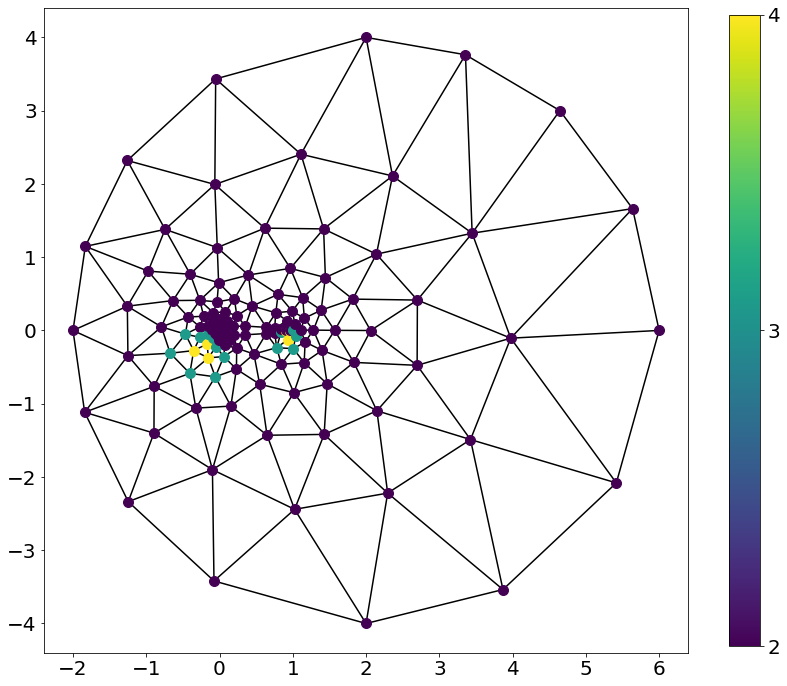

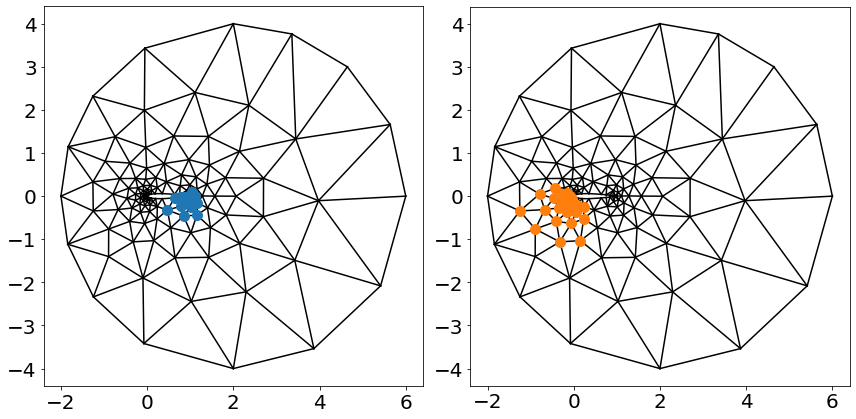

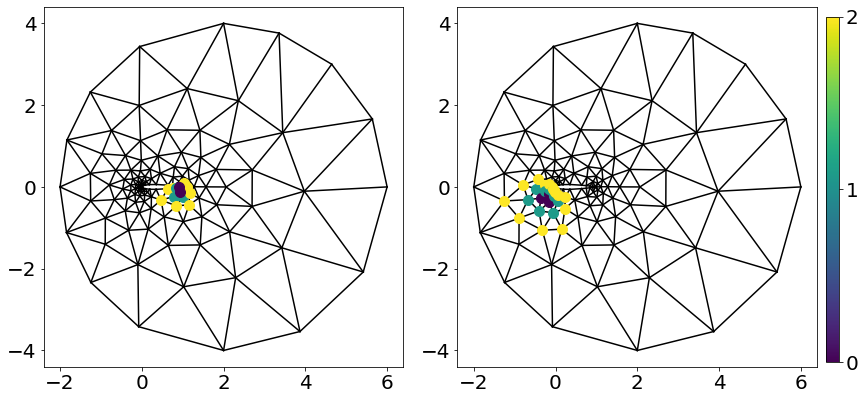

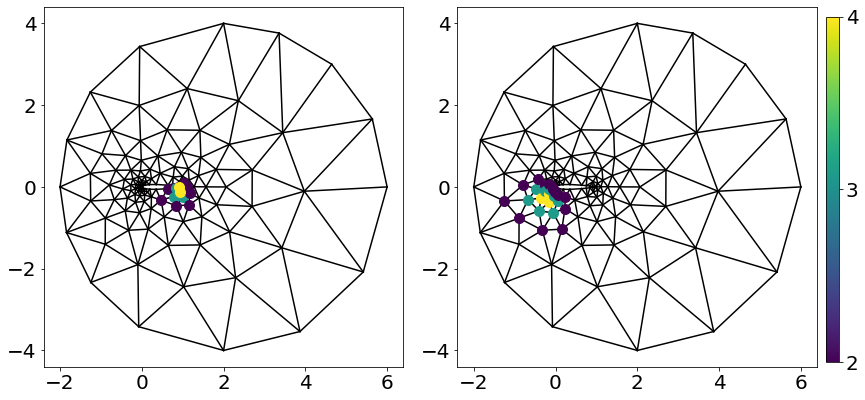

In [32]:
## OUTPUT PLOTS AND INFORMATION ##

# Print out information pertaining to the lower pyramidal step
numSubdomainsLowerPyramidal = len(territorySetLowerPyramidal)
print("There are " + str(numSubdomainsLowerPyramidal) + " subdomains/processors/GPU blocks in this step")
for i in range(numSubdomainsLowerPyramidal):
    print("Subdomain " + str(i) + "- DOFs are: " + str(territorySetLowerPyramidalExpanded[i]))
    print("                       only the following DOFs are updated: " + str(territorySetLowerPyramidal[i]))

# Final Visualization and save files if desired
visualizeAndSaveFiguresLowerPyramidal(territorySetLowerPyramidalExpanded, groundLevel, groundLevelBefore, saveFlag = saveFiguresFlag, imshowStyle = imshowFlag)

## STEP 4: DUAL BRIDGES

In [33]:
def visualizeAndSaveDualBridge(territorySetSeeds, filament, dualBridges, territorySetDualBridge, groundLevel, groundLevelBefore, saveFlag = False, imshowStyle = False):
    # Establish file names
    seedTerritoryFile = ""
    allDualBridgeDofsFile = ""
    dualBridgesFile = ""
    territoryFile = ""
    groundLevelFile = ""
    subdomainsFile = ""
    subdomainsGroundLevelBeforeFile = ""
    subdomainsGroundLevelAfterFile = ""
    if saveFlag == True:
        if airfoilMeshFlag == True:
            baseName = 'Dual_Bridge/dualBridge_' + 'seeds' + str(len(seeds)) + '_airfoil'
        else: 
            baseName = 'Dual_Bridge/dualBridge_' + 'N' + str(N) + '_' + 'seeds' + str(len(seeds)) + '_square'
        seedTerritoryFile = baseName + "_seedTerritory.png"
        allDualBridgeDofsFile = baseName + '_filament.png'
        dualBridgesFile = baseName + '_bridges.png'
        territoryFile = baseName + '_territories.png'
        groundLevelFile = baseName + '_groundLevel.png'
        subdomainsFile = baseName + '_subdomains.png'
        subdomainsGroundLevelBeforeFile = baseName + '_subdomainsGroundLevelBefore.png'
        subdomainsGroundLevelAfterFile = baseName + '_subdomainsGroundLevelAfter.png'
    # Plot and possibly save figures
    plotTerritories(territorySetSeeds, imshowStyle, seedTerritoryFile)
    plotTerritories([filament], imshowStyle, allDualBridgeDofsFile, legendFlag=False)
    plotSeeds(dualBridges, imshowStyle, dualBridgesFile, dual=True, bridge=True)
    plotTerritories(territorySetDualBridge, imshowStyle, territoryFile)
    plotGroundLevel(groundLevel, imshowStyle, groundLevelFile)
    # Subdomain Plots
    plotTerritoriesSubdomains(territorySetDualBridgeExpanded, imshowStyle, subdomainsFile)
    plotTerritoriesSubdomainsGroundLevel(territorySetDualBridgeExpanded, groundLevelBefore, imshowStyle, subdomainsGroundLevelBeforeFile)
    plotTerritoriesSubdomainsGroundLevel(territorySetDualBridgeExpanded, groundLevel, imshowStyle, subdomainsGroundLevelAfterFile)
    return 0

In [34]:
## STAGE 4: DUAL BRIDGE STAGE MAIN ##

# Obtain the filament regions
# filament = obtainFilamentBridgeRegion(seeds, groundLevel) 
iIter, territories, stopper, fronts = advance(seeds, max(groundLevel)-min(groundLevel), zeros(len(groundLevel)))
filament = set(np.where(territories == -1)[0])  
territorySetSeeds = territorySetCreator(territories)
filament = filamentRemoveSeeds(filament, dualSeeds)

# Use METIS to cut the filament region into different pieces
nparts = 4
filamentConnectivity = filamentConnectivityConstructor(filament, neighbors, groundLevel)
map, reverseMap = filamentMappingforMETIS(filament)
filamentMapped, filamentConnectivityMapped = constructMappedFilamentAndConnectivity(filament, filamentConnectivity, map)
xadj1, adjncy1, eweights1 = constructMETISDataStructures(filamentMapped, filamentConnectivityMapped)
n_cuts, membership = pymetis.part_graph(nparts, xadj=xadj1, adjncy=adjncy1, eweights=eweights1)
dualBridges = membershipToBridges(nparts, membership, reverseMap)

# Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
dualBridgeSeeds = dualBridges
iIter = int(max(groundLevel)) - int(min(groundLevel)) 
_, territories, _ = advanceKeepGoing(dualBridgeSeeds, int(max(groundLevel)), groundLevel)
territorySetDualBridge = territorySetCreator(territories)
territorySetDualBridgeExpanded = expandTerritorySet(territorySetDualBridge, neighbors)

# Record previous ground level
groundLevelBefore = groundLevel

# Advance
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetDualBridgeExpanded, dualBridgeSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetDualBridgeExpanded, dualBridgeSeeds, iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetDualBridge)
else:
    iIter, territories, stopper, fronts = advance([filament], max(groundLevel)+1, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)

In [35]:
## OUTPUT PLOTS AND INFORMATION ##

# Print out information pertaining to the bridge step
numSubdomainsDualBridge = len(territorySetDualBridge)
print("There are " + str(numSubdomainsDualBridge) + " subdomains/processors/GPU blocks in this step")
for i in range(numSubdomainsDualBridge):
    print("Subdomain " + str(i) + "- DOFs are: " + str(territorySetDualBridgeExpanded[i]))
    print("                       only the following DOFs are updated: " + str(territorySetDualBridge[i]))

visualizeAndSaveDualBridge(territorySetSeeds, filament, dualBridges, territorySetDualBridge, groundLevel, groundLevelBefore, saveFlag = saveFiguresFlag, imshowStyle = imshowFlag)

Output hidden; open in https://colab.research.google.com to view.

## LAST STEP

In [36]:
def visualizeAndSaveFiguresFinal(territorySetSeedsExpanded, groundLevel, groundLevelBefore, saveFlag = False, imshowStyle = False):
    # Establish file names
    groundLevelFile = ""
    subdomainsFile = ""
    subdomainsGroundLevelBeforeFile = ""
    subdomainsGroundLevelAfterFile = ""
    if saveFlag == True:
        if airfoilMeshFlag == True:
            baseName = 'Final_Configuration/final_' + 'seeds' + str(len(seeds)) + '_airfoil'
        else: 
            baseName = 'Final_Configuration/final_' + 'N' + str(N) + '_' + 'seeds' + str(len(seeds)) + '_square'
        groundLevelFile = baseName + '_groundLevel.png'
        subdomainsFile = baseName + '_subdomains.png'
        subdomainsGroundLevelBeforeFile = baseName + '_subdomainsGroundLevelBefore.png'
        subdomainsGroundLevelAfterFile = baseName + '_subdomainsGroundLevelAfter.png'
    # Plot and possibly save figures
    plotGroundLevel(groundLevel, imshowStyle, groundLevelFile)
    # Subdomain Plots
    plotTerritoriesSubdomains(territorySetSeedsExpanded, imshowStyle, subdomainsFile)
    plotTerritoriesSubdomainsGroundLevel(territorySetSeedsExpanded, groundLevelBefore, imshowStyle, subdomainsGroundLevelBeforeFile)
    plotTerritoriesSubdomainsGroundLevel(territorySetSeedsExpanded, groundLevel, imshowStyle, subdomainsGroundLevelAfterFile)
    return 0

In [37]:
# Define number of iterations to perform
iIter = int(max(groundLevel))

# Expand seed territories
territorySetSeedsExpanded = expandTerritorySet(territorySetSeeds, neighbors)

# Record ground level before
groundLevelBefore = groundLevel

# Advance
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetUpperPyramidal, territorySetUpperPyramidal, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, neighbors, territorySetUpperPyramidal, territorySetUpperPyramidal, iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetUpperPyramidal)
else:
    iIter, territories, stopper, fronts = advance(seeds, 0, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)

0

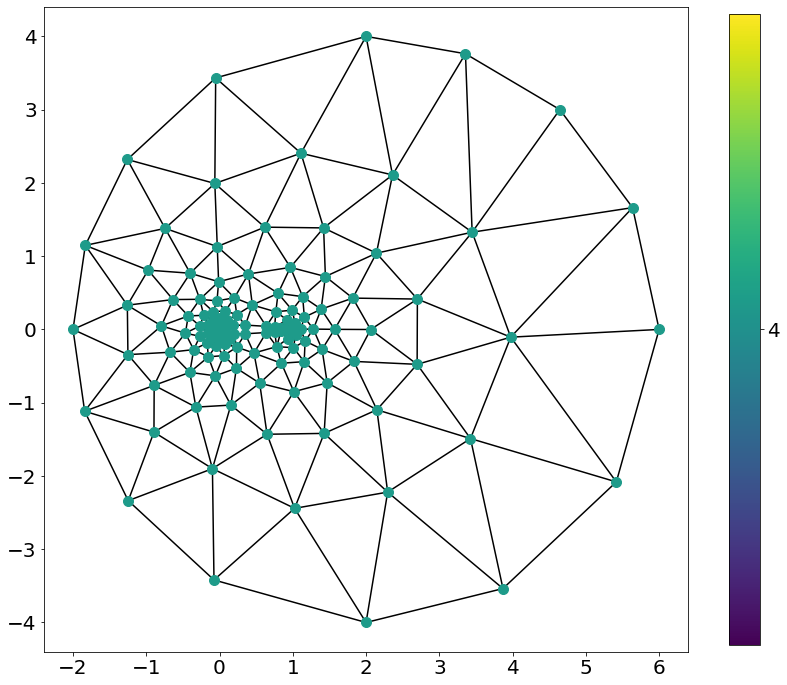

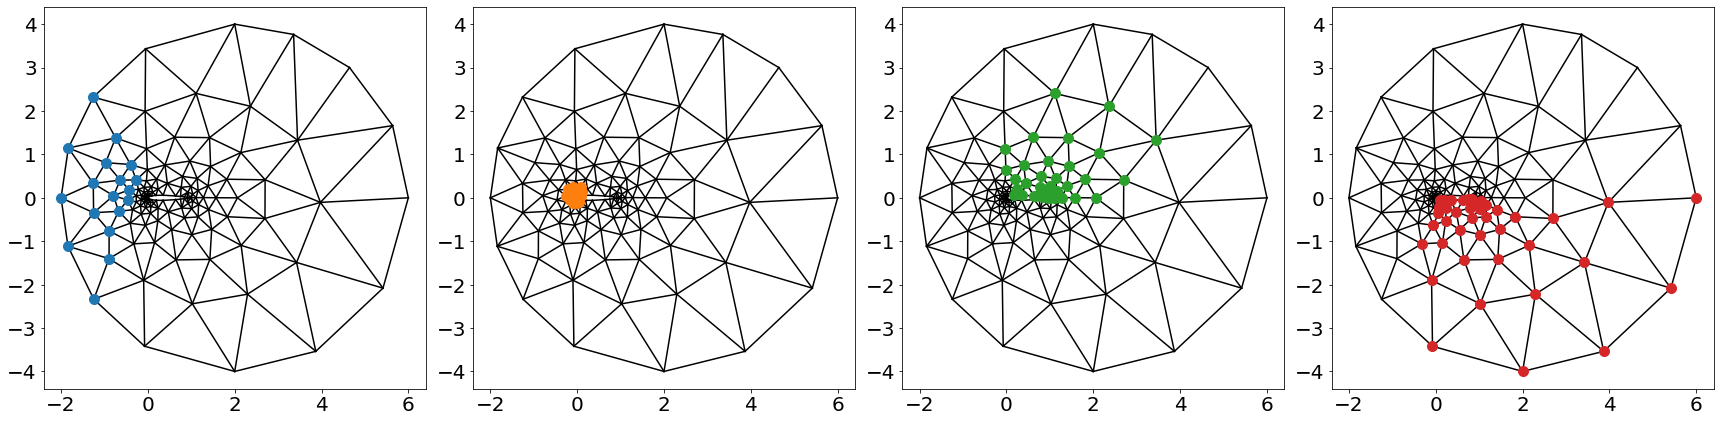

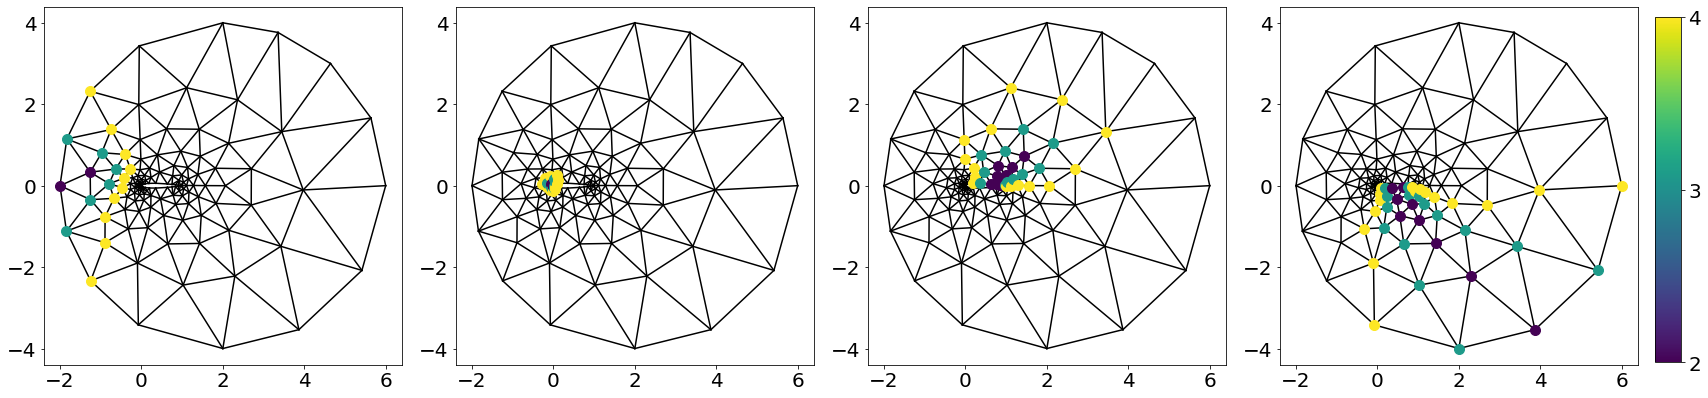

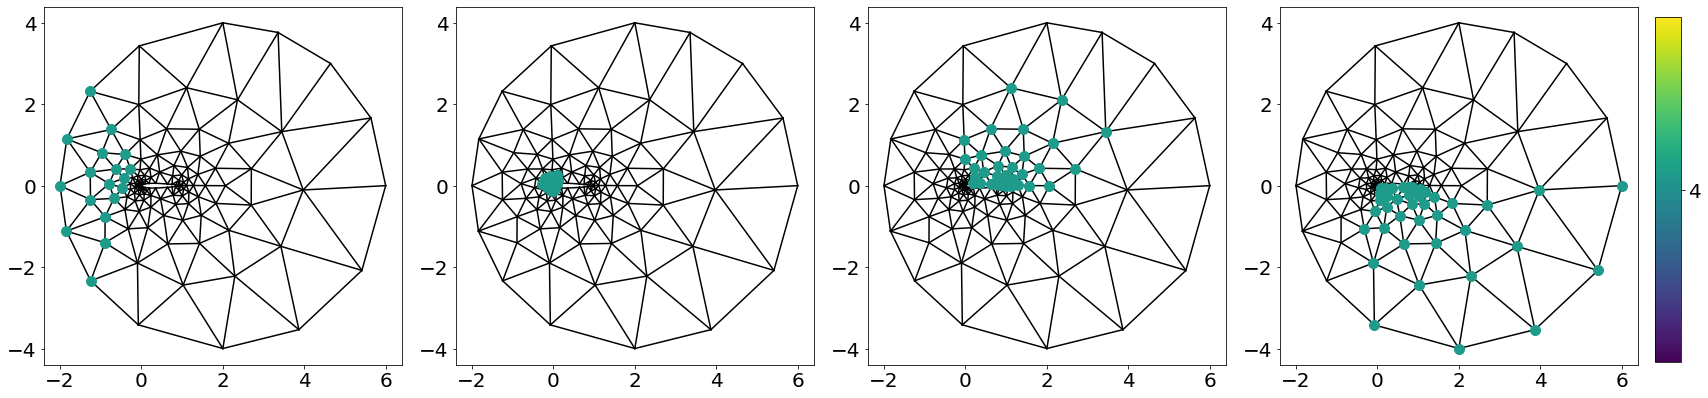

In [42]:
# Plot Ground Level

# Final Visualization and save files if desired
visualizeAndSaveFiguresFinal(territorySetSeedsExpanded, groundLevel, groundLevelBefore, saveFlag = saveFiguresFlag, imshowStyle = imshowFlag)

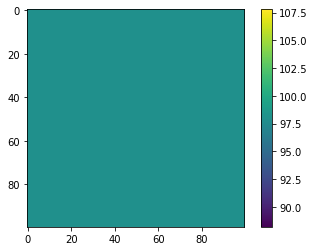

In [ ]:
# Plot Ground Level
plotGroundLevel(groundLevel, imshowStyle=imshowFlag)
savefig("final_configuration.png", dpi = 300)

## STEP 5: Repeat step 1


In [ ]:
def stageAdvance(groundLevel, seeds, territorySet, territorySetExpanded, neighbors, nIters, PARALLEL_FLAG=True):
    if PARALLEL_FLAG == True:
        # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
        groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetExpanded, seeds, neighbors)
        groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetExpanded, seeds, nIters, neighbors)
        groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySet)
    else:
        # Advance
        iIter, territories, stopper, fronts = advance(seeds, 0, groundLevel)
        groundLevel = frontsToGroundLevel(fronts)
    return groundLevel

In [ ]:
## Repeat upper pyramidal, bridge, lower pyramidal, dual bridge
numAdditionalCycles = 1
iIter, territories, stopper, _ = advance(seeds, 0, groundLevel)
iIter = iIter - int(max(groundLevel))
for cycle in arange(1,numAdditionalCycles+1):
    ## STAGE 1: UPPER PYRAMIDAL STAGE ##
    groundLevel = stageAdvance(groundLevel, seeds, territorySetUpperPyramidal, territorySetUpperPyramidal, neighbors, iIter, PARALLEL_FLAG=True)
    plotGroundLevel(groundLevel, N)
    ## STAGE 2: BRIDGE STAGE ##
    groundLevel = stageAdvance(groundLevel, bridgeSeeds, territorySetBridge, territorySetBridgeExpanded, neighbors, iIter, PARALLEL_FLAG=True)
    plotGroundLevel(groundLevel, N)
    ## STAGE 3: LOWER PYRAMIDAL STAGE ##
    groundLevel = stageAdvance(groundLevel, dualSeeds, territorySetLowerPyramidal, territorySetLowerPyramidalExpanded, neighbors, 2*iIter, PARALLEL_FLAG=True)
    plotGroundLevel(groundLevel, N)
    ## STAGE 4: DUAL BRIDGE SEEDS ##
    groundLevel = stageAdvance(groundLevel, dualBridgeSeeds, territorySetDualBridge, territorySetDualBridgeExpanded, neighbors, iIter, PARALLEL_FLAG=True)
    plotGroundLevel(groundLevel, N)
    ## FINAL (OPTIONAL) TO BRING TO ORIGINAL CONFIGURATION
    groundLevel = stageAdvance(groundLevel, territorySetUpperPyramidal, territorySetUpperPyramidal, territorySetUpperPyramidal, neighbors, iIter, PARALLEL_FLAG=True)
    plotGroundLevel(groundLevel, N)

ValueError: ignored

<Figure size 432x288 with 0 Axes>

### The long way...

In [ ]:
## Repeat upper pyramidal, bridge, lower pyramidal, dual bridge

## STAGE 1: UPPER PYRAMIDAL STAGE ##
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetUpperPyramidalExpanded, seeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetUpperPyramidalExpanded, seeds, 2*iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetUpperPyramidal)
else:
    # Advance using the bridge
    groundLevel = lowerPyramidal(neighbors, groundLevel)
# Plot Ground Level
plotGroundLevel(groundLevel, N)

In [ ]:
## STAGE 2: BRIDGE STAGE ##
iIter = int(max(groundLevel)) - int(min(groundLevel)) 
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetBridgeExpanded, bridgeSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetBridgeExpanded, bridgeSeeds, iIter, neighbors) 
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetBridge)
else:
    # Advance using the bridge
    iIter, territories, stopper, fronts = advance(bridgeSeeds, 0, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)
# Plot Ground Level
plotGroundLevel(groundLevel, N)

In [ ]:
## STAGE 3: LOWER PYRAMIDAL STAGE ##
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetLowerPyramidalExpanded, dualSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetLowerPyramidalExpanded, dualSeeds, 2*iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetLowerPyramidal)
else:
    # Advance using the bridge
    groundLevel = lowerPyramidal(neighbors, groundLevel)

# Plot Ground Level
plotGroundLevel(groundLevel, N)

In [ ]:
## STAGE 4: DUAL BRIDGE SEEDS ##
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetDualBridgeExpanded, dualBridgeSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetDualBridgeExpanded, dualBridgeSeeds, iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetDualBridge)
else:
    iIter, territories, stopper, fronts = advance([filament], max(groundLevel)+1, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)

# Plot Ground Level
plotGroundLevel(groundLevel, N)